#1. Introduction

This colab provides the code for Crossvalidation to asses the performance of the BERT base uncased model. This version is **stable**. The files you will need for this colab are "PETv1.1-entities.jsonl" and "complete_combined_leschneiderdata_NER.jsonl". The paths of which you need to specify.

##1.1 Preliminary Code

The code below provides the necesary libraries, paths to the input data and initial variable setups.

In [ ]:
#@title Importing and setting variables
import torch
import json
from transformers import BertTokenizer, BertForTokenClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import RobertaTokenizer, RobertaForTokenClassification
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files
import random
import copy

# Set a fixed seed for all random operations
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# If you're using CUDA:
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


drive.mount('/content/drive/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#setting up the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

#Is needed for the translation between floats and labels, as BERT's output is a float.
label_map = {
    "O": 0,
    "B-Actor": 1, "I-Actor": 2,
    "B-Activity": 3, "I-Activity": 4,
    "B-Activity Data": 5, "I-Activity Data": 6,
    "B-Further Specification": 7, "I-Further Specification": 8,
    "B-XOR Gateway": 9, "I-XOR Gateway": 10,
    "B-Condition Specification": 11, "I-Condition Specification": 12,
    "B-AND Gateway": 13, "I-AND Gateway": 14
}

short_label_map = {
    "O": 0,
    "Actor": 1,
    "Activity": 2,
    "Activity Data": 3,
    "Further Specification": 4,
    "XOR Gateway": 5,
    "Condition Specification": 6,
    "AND Gateway": 7
}

# Reverse map for evaluation purposes
reverse_label_map = {v: k for k, v in label_map.items()}
NUM_LABELS = len(label_map)  # Correctly reflects the actual classification labels


Mounted at /content/drive/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Constants, can be changed for model optimisation
MAX_LEN = 128  # Or any max length suited to your data
BATCH_SIZE = 8
EPOCHS = 7

In [ ]:
#@title Printing Model Output Code
def print_token_predictions_true_labels(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Ensure the model is in evaluation mode
    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits

        # Convert logits to predicted label IDs
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            # Decode the input IDs to tokens
            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)

            # Skip special tokens for true and predicted labels
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens and Labels:")
            for token, true_label, pred_label in zip(tokens, true_labels, pred_labels):
                print(f"{token}\tTrue: {true_label}\tPred: {pred_label}")
            print("\n")

            samples_printed += 1


def print_token_true_labels_per_sentence_excluding_special_tokens(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Move model to the correct device and set to evaluation mode

    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop after reaching the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to the correct device

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)
            true_labels = [reverse_label_map[label_id] for label_id in true_label_ids]

            # Filter tokens and labels to exclude special tokens and corresponding labels
            filtered_tokens_and_labels = [
                (token, label) for token, label, mask in zip(tokens, true_labels, attention_mask)
                if mask == 1 and token not in tokenizer.all_special_tokens
            ]

            filtered_tokens = [token for token, _ in filtered_tokens_and_labels]
            filtered_true_labels = [label for _, label in filtered_tokens_and_labels]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens:")
            print(filtered_tokens)
            print("True Labels:")
            print(filtered_true_labels)
            print("\n")

            samples_printed += 1

# Ensure you have your val_dataloader, model, tokenizer, and reverse_label_map properly defined before calling this function.

def output_predictions_to_excel(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5, file_name='output.xlsx'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Ensure the model is in evaluation mode and moved to the right device
    samples_printed = 0

    # Prepare DataFrame
    columns = ['Token', 'True Label', 'Predicted Label']
    data = []

    for batch in val_dataloader:
        #if samples_printed >= num_samples:
            #break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            #if samples_printed >= num_samples:
                #break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            # Append each token and its labels to the data list
            data.extend([(token, true, pred) for token, true, pred in zip(tokens, true_labels, pred_labels)])

            samples_printed += 1

    # Create DataFrame and write to Excel
    file_path = f"/content/drive/MyDrive/THESIS/CODING/BERT outputs/BERT predictions/{file_name}"
    df = pd.DataFrame(data, columns=columns)
    df.to_excel(file_path, index=False)

    print(f"Output written to {file_path}")

# Ensure your model, tokenizer, and dataloader are properly initialized before calling this function.


In [ ]:
#@title Initialization of necessary functions for crossvalidation and training of BERT

#This function is grouping and loading data per doc-id such that they are processed per doc-id. The function expects a path to a .json file
def load_and_group_ner_data(file_path):
    grouped_data = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line)
            document_name = entry['document name']  # Adjusted to use 'document name'
            if document_name not in grouped_data:
                grouped_data[document_name] = []
            grouped_data[document_name].append(entry)
            #print(entry)
    # Sort each group by 'sentence-ID'
    for doc in grouped_data.values():
        doc.sort(key=lambda x: x['sentence-ID'])

    return list(grouped_data.values())

#For the calculation of accuracy metrics
def calculate_f1(model, dataloader, device):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        check_true, check_pred = set(), set()
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            # Flatten labels and predictions
            batch_labels = batch['labels'].detach().cpu().numpy()
            batch_predictions = predictions.detach().cpu().numpy()

            true_labels.extend(batch_labels.flatten())
            pred_labels.extend(batch_predictions.flatten())
            check_true.update(true_labels)
            check_pred.update(pred_labels)


    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    return precision, recall, f1


#This class tokenizes the sentences and their words according to the predefined tokenizer for BERT. Also maps the labels to their integer number values.
class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len, label_map):
        self.sentences = sentences  # List of sentences (each sentence is a list of words)
        self.labels = labels        # List of label sequences corresponding to each sentence
        self.tokenizer = tokenizer  # BERT tokenizer
        self.max_len = max_len      # Maximum sequence length
        self.label_map = label_map  # Mapping from label strings to integers

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        word_labels = self.labels[idx]

        # Tokenize words and align labels with tokens
        tokens = []
        aligned_labels = []
        for word, label in zip(words, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Extend the label to all subwords
            aligned_labels.extend([label] * len(word_tokens))

        # Truncate tokens and labels if they exceed max_len
        tokens = tokens[:self.max_len-2]
        aligned_labels = aligned_labels[:self.max_len-2]

        # Convert tokens and labels to model inputs
        input_ids = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])
        attention_mask = [1] * len(input_ids)
        label_ids = [self.label_map['O']] + [self.label_map[label] for label in aligned_labels] + [self.label_map['O']]

        # Padding
        padding_length = self.max_len - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        label_ids += [self.label_map['O']] * padding_length

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }

#This function employs a BERT model training where no early stopping is used
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Directory where you want to save your model checkpoints
    os.makedirs(checkpoint_dir, exist_ok=True)

    #Initialize score
    best_f1_score = 0.0

    #In order to plot the validation and training losses to check for overfitting
    training_losses = []
    validation_losses = []

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        print("Training...")
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            scheduler.step()

            if step % 100 == 0 or step == len(train_dataloader) - 1:
                precision, recall, f1 = calculate_f1(model, val_dataloader, device)
                print(f"Step {step}, Loss: {loss.item():.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f'Average training loss: {avg_train_loss:.4f}\n')

        training_losses.append(avg_train_loss)

        # In each epoch we validate the current model so to get the Validation Loss for plotting.
        val_metrics = evaluate_model(model, val_dataloader, label_map)
        validation_losses.append(val_metrics['avg_val_loss'])

    return model, training_losses, validation_losses

#This function employs a BERT model training where early stopping is used
def train_model_with_early_stopping(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, patience, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_f1_score = 0.0
    patience_counter = 0

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            scheduler.step()

        precision, recall, f1 = calculate_f1(model, val_dataloader, device)
        print(f"Epoch {epoch_i + 1}, Validation Precision: {precision}, Recall: {recall}, F1: {f1}")

        if f1 > best_f1_score:
            best_f1_score = f1
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            print("Validation F1 Score improved. Saving model checkpoint.")
        else:
            patience_counter += 1
            print("Validation F1 Score did not improve.")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        print(f'Epoch {epoch_i + 1} completed.\n')

    # Load the best model after training ends
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pth')))



In [ ]:
#@title convert_IOB2_to_chunks
def convert_IOB2_to_chunks(nested_label_list, reverse_label_map):

    all_chunks = []
    #print(nested_label_list)
    for sentence in nested_label_list:
        #print(sentence)
        chunks = []
        current_chunk = []
        current_type = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if label.startswith('B-'):
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = label[2:]
                current_chunk = [idx, idx]  # Start a new chunk

            elif label.startswith('I-') and current_type == label[2:]:
                current_chunk[1] = idx  # Extend the current chunk

            elif label == 'O':
                if current_chunk:  # End current chunk before starting 'O' chunk
                    chunks.append((current_type, current_chunk))
                current_type = 'O'
                current_chunk = [idx, idx]  # Start a new 'O' chunk immediately


            else:  # For non-matching 'I-' or different entity types
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = None

        if current_chunk:  # Add the last chunk if exists
            chunks.append((current_type, current_chunk))

        all_chunks.append(chunks)

    return all_chunks

In [ ]:
#@title Evaluation helper functions
def calculate_metrics_per_sentence_by_label(true_chunks_all_sentences, pred_chunks_all_sentences):
    # Initialize counters for true positives, false positives, and false negatives per label
    tp_dict = defaultdict(int)
    fp_dict = defaultdict(int)
    fn_dict = defaultdict(int)
    support_dict = defaultdict(int)


    labels = set(label for sentence in true_chunks_all_sentences + pred_chunks_all_sentences for label, _ in sentence)


    #For the calculation of support
    for true_chunks in true_chunks_all_sentences:
        for label, _ in true_chunks:
            support_dict[label] += 1

    #For the calculation of precision, recall and F1
    for true_chunks, pred_chunks in zip(true_chunks_all_sentences, pred_chunks_all_sentences):
        true_set = set((label, tuple(indices)) for label, indices in true_chunks)
        pred_set = set((label, tuple(indices)) for label, indices in pred_chunks)

        # True Positives per label
        for label, indices in true_set & pred_set:
            tp_dict[label] += 1

        # False Positives per label
        for label, indices in pred_set - true_set:
            fp_dict[label] += 1

        # False Negatives per label
        for label, indices in true_set - pred_set:
            fn_dict[label] += 1

    # Calculate metrics per label
    metrics_per_label = {}
    for label in labels:
        tp = tp_dict[label]
        fp = fp_dict[label]
        fn = fn_dict[label]
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        support = support_dict[label]

        metrics_per_label[label] = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Support": support,
            "TP": tp,
            "FP": fp,
            "FN": fn
        }

    return metrics_per_label

def calculate_macro_averaged_f1(metrics_per_label):
    f1_scores = [metrics['F1'] for metrics in metrics_per_label.values()]
    macro_averaged_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0
    return macro_averaged_f1

def calculate_micro_f1(metrics_per_label):
    # Initialize counters for total TP, FP, and FN
    total_tp = 0
    total_fp = 0
    total_fn = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the TP, FP, and FN for the current label
        tp = metrics["TP"]
        fp = metrics["FP"]
        fn = metrics["FN"]

        # Accumulate the total TP, FP, and FN
        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Calculate micro precision and recall
    if (total_tp + total_fp) > 0:
        micro_precision = total_tp / (total_tp + total_fp)
    else:
        micro_precision = 0

    if (total_tp + total_fn) > 0:
        micro_recall = total_tp / (total_tp + total_fn)
    else:
        micro_recall = 0

    # Calculate micro F1 score
    if (micro_precision + micro_recall) > 0:
        micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    else:
        micro_f1 = 0

    return micro_f1

def calculate_weighted_f1(metrics_per_label):

    # Initialize variables for the sum of weighted F1 scores and the total support
    weighted_f1_sum = 0
    total_support = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the F1 score and support for the current label
        f1_score = metrics["F1"]
        support = metrics["Support"]

        # Add the product of the current label's F1 score and its support to the sum of weighted F1 scores
        weighted_f1_sum += f1_score * support

        # Add the current label's support to the total support
        total_support += support

    # Calculate the overall weighted F1 score by dividing the sum of weighted F1 scores by the total support
    if total_support > 0:
        overall_weighted_f1 = weighted_f1_sum / total_support
    else:
        overall_weighted_f1 = 0

    return overall_weighted_f1

def convert_int_2string(nested_label_list, reverse_label_map):

    all_chunks = []

    for sentence in nested_label_list:
        chunks = []
        current_chunk = []
        current_label = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if current_label is None or current_label != label:
                if current_chunk:
                    chunks.append((current_label, current_chunk))
                current_label = label
                current_chunk = [idx, idx]
            else:
                current_chunk[1] = idx

        if current_chunk:
            chunks.append((current_label, current_chunk))

        all_chunks.append(chunks)

    return all_chunks


def get_sorted_labels(val_metrics):

    pairs = []
    non_paired_labels = []

    for label in sorted(val_metrics['detailed_metrics'].keys()):  # Sort keys to maintain alphabetical order
        if label.startswith("B-"):
            corresponding_i_label = f"I-{label[2:]}"
            if corresponding_i_label in val_metrics['detailed_metrics']:
                pairs.append((label, corresponding_i_label))
            else:
                non_paired_labels.append(label)  # Add B- label if I- counterpart not found
        elif not label.startswith("I-"):  # This will automatically handle 'O' and other non B-/I- labels
            non_paired_labels.append(label)

    # Flatten the sorted pairs
    sorted_labels = [label for pair in pairs for label in pair]

    # Add non-paired labels at the end
    sorted_labels.extend(non_paired_labels)

    return sorted_labels

The next functions are used for model evaluation

In [ ]:
#@title Main Evaluation function & Plotting
def evaluate_model(model, val_dataloader, label_map):
    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Switch the model to evaluation mode to disable dropout layers
    model.eval()

    # Initialize variables to accumulate loss and store predictions and true labels
    eval_loss = 0
    nb_eval_steps = 0
    true_labels = []
    pred_labels = []

    # Iterate over batches in the validation dataloader
    for batch in val_dataloader:
        # Move batch data to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Perform inference (forward pass) without computing gradients
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            eval_loss += outputs.loss.item()

        # Convert logits to predicted class indices
        preds = np.argmax(logits.detach().cpu().numpy(), axis=2)

        # Collect true and predicted labels for each sentence in the batch
        for i in range(batch["input_ids"].shape[0]):
            # Use attention mask to filter out padding tokens
            mask = batch["attention_mask"][i].cpu().numpy()
            true_sequence = batch["labels"][i].cpu().numpy()[mask == 1]
            pred_sequence = preds[i][mask == 1]

            # Append individual sentence-level lists
            true_labels.append(true_sequence.tolist())  # Convert to list for consistency
            pred_labels.append(pred_sequence.tolist())

        nb_eval_steps += 1

    #Then passed it through a function that converts the predictions into entities and at the same time from a integer to a string. We do this for the True and Predicted labels altogether
    #We get something like ['Actor', [1, 3]]
    #true_labels_entities = convert_IOB2_to_chunks(true_labels, reverse_label_map)
    #pred_labels_entities = convert_IOB2_to_chunks(pred_labels, reverse_label_map)

    true_labels_entities = convert_int_2string(true_labels, reverse_label_map)
    pred_labels_entities = convert_int_2string(pred_labels, reverse_label_map)
    #print(f"after {true_labels_entities}")
    #print(f"before {pred_labels_entities}")


    #We calculate metrics per label
    #label_metrics = compare_entities(true_labels_entities, pred_labels_entities)
    label_metrics = calculate_metrics_per_sentence_by_label(true_labels_entities, pred_labels_entities)

    #The averaged F1 where you treat each class equally without considering the labels frequency.
    macro_averaged_f1 = calculate_macro_averaged_f1(label_metrics)
    print(f"Macro-Averaged F1 Score: {macro_averaged_f1:.4f}\n")

    micro_average_f1 = calculate_micro_f1(label_metrics)
    print(f"Micro-Averaged F1 Score: {micro_average_f1:.4f}\n")

    #The weighted F1 accounts for the frequency in which a label occurs
    weighted_average_f1 = calculate_weighted_f1(label_metrics)
    print(f"Weigthed-Averaged F1 Score: {weighted_average_f1:.4f}\n")

    # Calculate average validation loss
    avg_val_loss = eval_loss / nb_eval_steps

    # Print average validation loss
    #print(f"Validation Loss: {avg_val_loss}\n")

    detailed_metrics = {}
    # Print metrics per label and aggregate them into detailed_metrics dictionary
    for label, metrics in label_metrics.items():
      precision = metrics['Precision']
      recall = metrics['Recall']
      f1 = metrics['F1']
      support = metrics['Support']

      detailed_metrics[label] = {
          'precision': precision,
          'recall': recall,
          'f1': f1,
          'support': support}

    # Return a dictionary with detailed metrics per label, weighted F1 score, and average validation loss
    return {
        'detailed_metrics': detailed_metrics,
        'macro_averaged_f1': macro_averaged_f1,
        'micro_averaged_f1': micro_average_f1,
        'weighted_average_f1': weighted_average_f1,
        'avg_val_loss': avg_val_loss
    }

#This function returns a confusion matrix between the true and predicted labels
def plot_confusion_matrix(true_labels, pred_labels, reverse_label_map):

    # Convert label IDs back to their string representations
    true_labels_str = [reverse_label_map[label] for label in true_labels]
    pred_labels_str = [reverse_label_map[label] for label in pred_labels]

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels_str, pred_labels_str, labels=list(reverse_label_map.values()))

    # Visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(reverse_label_map.values()), yticklabels=list(reverse_label_map.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

#This plot shows the overfitting of our model
def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(training_losses) + 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss', linestyle="--")

    #Find the minimum validation loss and its corresponding epoch
    min_val_loss = min(validation_losses)
    min_val_loss_epoch = validation_losses.index(min_val_loss) + 1  # Adding 1 because epochs start at 1

    # Draw a horizontal line at the minimum validation loss
    plt.axhline(y=min_val_loss, color='r', linestyle='--', label=f'Min Validation Loss: {min_val_loss:.4f}')

    # Draw a vertical line at the epoch of the minimum validation loss
    plt.axvline(x=min_val_loss_epoch, color='g', linestyle='--', label=f'Epoch: {min_val_loss_epoch}')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(visible=True)
    plt.show()



Below is the core function for the crossvalidation. **To adjust the model**, uncomment and comment the "model" from line 61.

In [ ]:
#@title Crossvalidation Function
#This code performs the cross_validation and trains the model n times.
def grouped_k_fold_cross_validation(data, splits: int(), batch_size, EPOCHS, label_map, learning_rate):


    # Step 1: Prepare group IDs for GroupKFold using the training+validation data
    # Recalculate group IDs to reflect only the groups within train_val_data
    unique_docs = set(item['document name'] for item in data)
    doc_to_id = {doc_name: i for i, doc_name in enumerate(unique_docs)}
    group_ids = [doc_to_id[item['document name']] for item in data]

    # Step 2: Initializing GroupKFold Crossvalidation
    gkf = GroupKFold(n_splits=splits)

    #In order to compute an aggregate result through all folds at the end we need to keep a list.
    all_fold_results = []
    # Initialize a dictionary to accumulate F1 scores for each label across folds
    label_f1_scores = {label: [] for label in label_map.keys()}
    label_P_scores = {label: [] for label in label_map.keys()}
    label_R_scores = {label: [] for label in label_map.keys()}

    # To chose the best performing model
    models_and_metrics = {}

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X=data, groups=group_ids)):
        print(f"Fold {fold+1}")

        #We split the entire dataset based on train_idx and val_idx given by the GroupKFold module.
        #It ensures no two identical groups are presented as a validation set twice.
        train_subset = Subset(data, indices=train_idx)
        val_subset = Subset(data, indices=val_idx)

        # Instantiate the dataset and dataloader for training
        train_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in train_subset],
            labels=[entry['ner-tags'] for entry in train_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        # Instantiate the dataset and dataloader for validation
        val_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in val_subset],
            labels=[entry['ner-tags'] for entry in val_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        #Initialize the DataLoader objects
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

        #loading the desired model: each fold we need start fresh
        model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS)

        # Fine-tuning setup, can be changed for model optimisation
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
        total_steps = len(train_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        # Using funtion defined above to train the model and obtain the losses for plotting at the same time
        model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints')
        plot_losses(training_losses,validation_losses)

        #Evaluating the model in this fold
        val_metrics = evaluate_model(model, val_loader, label_map)

        all_fold_results.append(val_metrics)

        models_and_metrics[fold] = {
        "model": model,
        "val_metrics": val_metrics}

        # Open a file for output
        header = "{:<35} {:<10} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1", "Support")
        row_format = "{:<35} {:<10} {:<10} {:<10} {:<10}\n"
        print(header)

        # Call the function to get the sorted labels
        sorted_labels = get_sorted_labels(val_metrics)

        for label in sorted_labels:
            metrics = val_metrics['detailed_metrics'][label]
            print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1']), "{:.0f}".format(metrics['support'])))
            label_f1_scores[label].append(metrics['f1'])
            label_P_scores[label].append(metrics['precision'])
            label_R_scores[label].append(metrics['recall'])

        print("SUMMARY FOLD: \n")
        print(f"Macro Averaged F1 Score for fold {fold+1}: {val_metrics['macro_averaged_f1']:.4f}\n")
        print(f"Micro Averaged F1 Score for fold {fold+1}: {val_metrics['micro_averaged_f1']:.4f}\n")
        print(f"Weighted Averaged F1 Score for fold {fold+1}: {val_metrics['weighted_average_f1']:.4f}\n")

        #output_predictions_to_excel(val_loader, model, tokenizer, reverse_label_map, num_samples=5, file_name=f'output_fold{fold}.xlsx')
        #print_token_true_labels_per_sentence(val_loader, model, tokenizer, reverse_label_map, num_samples=2)
        #break

    # Save the best model
    best_fold = max(
        models_and_metrics,
        key=lambda x: models_and_metrics[x]["val_metrics"]["macro_averaged_f1"])

    best_model = models_and_metrics[best_fold]["model"]
    best_model_metrics = models_and_metrics[best_fold]["val_metrics"]

    # Initialize a variable to accumulate weighted F1 scores from each fold
    total_macro_f1 = 0
    total_micro_f1 = 0
    total_weighted_f1 = 0

    # Assuming you're still appending the results of evaluate_model to all_fold_results
    for results in all_fold_results:
        total_macro_f1 += results['macro_averaged_f1']
        total_micro_f1 += results['micro_averaged_f1']
        total_weighted_f1 += results['weighted_average_f1']

    # Calculate the average weighted F1 score across all folds
    print("---------------------------------------")
    print("\nTraining succesfully finished!\n")
    print("---------------------------------------\n")
    print("---------------------------------------")
    print(f"Best fold was fold {best_fold+1}\n")
    print("---------------------------------------\n")
    average_macro_f1 = total_macro_f1 / len(all_fold_results)
    average_micro_f1 = total_micro_f1 / len(all_fold_results)
    average_weighted_f1 = total_weighted_f1 / len(all_fold_results)
    print(f"Average Macro F1 Score Across All Folds: {average_macro_f1:.4f}")
    print(f"Average Micro F1 Score Across All Folds: {average_micro_f1:.4f}")
    print(f"Average Weighted F1 Score Across All Folds: {average_weighted_f1:.4f}")

    # Calculate and print average F1 scores, precision, and recall for each label across all folds
    row_format = "{:<35} {:<10} {:<10} {:<10}\n"
    print("Average Metrics per Label:\n")
    print(row_format.format("Label", "Precision", "Recall", "F1"))
    for label in sorted_labels:
        try:
            average_f1 = sum(label_f1_scores[label]) / len(label_f1_scores[label])
            average_precision = sum(label_P_scores[label]) / len(label_P_scores[label])
            average_recall = sum(label_R_scores[label]) / len(label_R_scores[label])
            print(row_format.format(label, "{:.4f}".format(average_precision), "{:.4f}".format(average_recall), "{:.4f}".format(average_f1)))
        except ZeroDivisionError:
            print(f"Zero division error for label {label}")

    return best_model, average_macro_f1, average_micro_f1, average_weighted_f1, label_f1_scores


Now that all functions have been initialized we can start calling them.

##1.2 Data Loading

First we need to load the data, since our combined data is in two seperate files we need to merge them first. Then, we need to tokenize (which happens in the groupfold function) and prepare the data so the model can understand it.

In [ ]:
#setting up the input data and merging them
#adjust according to dataset location
try:
  PET_Folder = '/content/drive/MyDrive/THESIS/DATA/PET/actual PET data from Patrizio Bellan/PETv1.1-entities.jsonl'
  LESCHNEIDER_Folder = '/content/drive/MyDrive/THESIS/DATA/LESCHNEIDER DATA/Documents/FORMATTED_DATA_ELEMENTS/complete_combined_leschneiderdata_NER.jsonl'

  # Load and group data from both files calling on a function above
  grouped_data_1 = load_and_group_ner_data(PET_Folder)
  grouped_data_2 = load_and_group_ner_data(LESCHNEIDER_Folder)

  # Append the contents of the second list to the first
  unflattened_data = grouped_data_1 + grouped_data_2 #Combined data

  #Because the data is grouped according to doc_name, the unflattened_data is a list that contains lists. By unpacking we create a list containing not lists but the actual documents.
  input_data = [item for group in unflattened_data for item in group] #Now input_data containts all the sentences.
  if input_data:
    print("Data Loaded")
    print(f"sample data: {input_data}")
except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")



Data Loaded
sample data: [{'document name': 'doc-10.1', 'sentence-ID': 0, 'tokens': ['The', 'MPON', 'sents', 'the', 'dismissal', 'to', 'the', 'MPOO', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'B-Actor', 'I-Actor', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 1, 'tokens': ['The', 'MPOO', 'reviews', 'the', 'dismissal', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 2, 'tokens': ['The', 'MPOO', 'opposes', 'the', 'dismissal', 'of', 'MPON', 'or', 'the', 'MPOO', 'confirmes', 'the', 'dismissal', 'of', 'the', 'MPON', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'B-XOR Gateway', 'B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'O', 'O']}, {'document name': 'doc-10.12', 'sentence-ID': 0, 'tokens': ['The', 'EC', 'tells', 'the', 'INQ', 'about', 'th

#2 Model Training & Learning Rate Evaluation

Now we will train the model using Grouped K Crossvalidation for each Learning Rate. Make sure you ran all cells before. **This will take a long time** depending on your configuration and computing power. Here we evaluate the learning rate, we conclude that a learning rate of 5e-5performs best together with an epoch of 5.


---------------------------------------
Learning Rate: 2e-05
---------------------------------------

Fold 1


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7739, Precision: 0.8249, Recall: 0.2640, F1: 0.3954
Step 50, Loss: 0.2699, Precision: 0.8575, Recall: 0.9171, F1: 0.8820
Average training loss: 0.5845

Macro-Averaged F1 Score: 0.0098

Micro-Averaged F1 Score: 0.0404

Weigthed-Averaged F1 Score: 0.0347

Epoch 2/7
Training...
Step 0, Loss: 0.2246, Precision: 0.8575, Recall: 0.9171, F1: 0.8820
Step 50, Loss: 0.2886, Precision: 0.9272, Recall: 0.9460, F1: 0.9353
Average training loss: 0.2302

Macro-Averaged F1 Score: 0.2530

Micro-Averaged F1 Score: 0.4499

Weigthed-Averaged F1 Score: 0.4378

Epoch 3/7
Training...
Step 0, Loss: 0.1822, Precision: 0.9275, Recall: 0.9465, F1: 0.9359
Step 50, Loss: 0.1440, Precision: 0.9385, Recall: 0.9574, F1: 0.9476
Average training loss: 0.1568

Macro-Averaged F1 Score: 0.3033

Micro-Averaged F1 Score: 0.5571

Weigthed-Averaged F1 Score: 0.5326

Epoch 4/7
Training...
Step 0, Loss: 0.1437, Precision: 0.9381, Recall: 0.9573, F1: 0.9473
Step 50, Loss: 0.0874, Precision: 

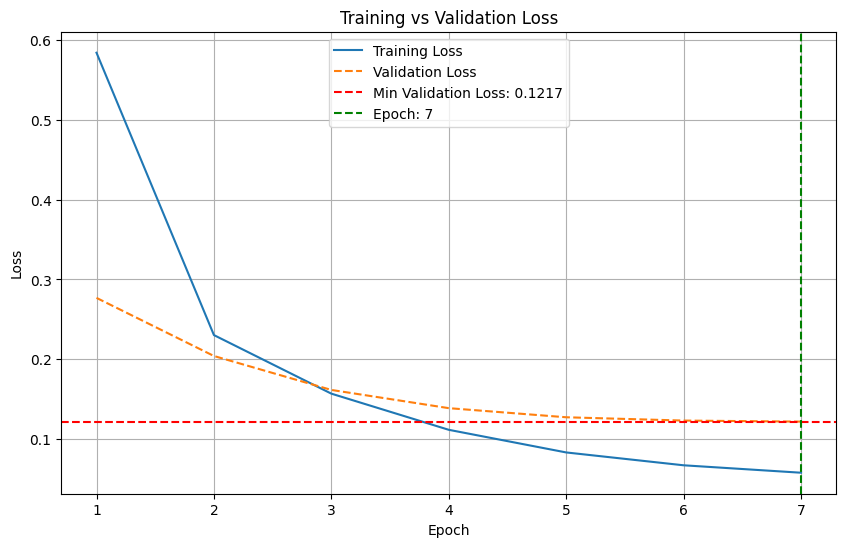

Macro-Averaged F1 Score: 0.4189

Micro-Averaged F1 Score: 0.6688

Weigthed-Averaged F1 Score: 0.6370

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     10        

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8372     0.9076     0.8710     119       

I-Activity                          0.0000     0.0000     0.0000     11        

B-Activity Data                     0.8384     0.7615     0.7981     109       

I-Activity Data                     0.5078     0.6500     0.5702     100       

B-Actor                             0.8000     0.9167     0.8544     96        

I-Actor                             0.6700     0.8171     0.7363     82        

B-Condition Specification           1.0000     0.4000     0.5714     10        

I-Condition Specification           0.5000     0.4000     0.4444     10        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5301, Precision: 0.8481, Recall: 0.8086, F1: 0.8275
Step 50, Loss: 0.2985, Precision: 0.8742, Recall: 0.9186, F1: 0.8822
Average training loss: 0.5603

Macro-Averaged F1 Score: 0.0092

Micro-Averaged F1 Score: 0.0298

Weigthed-Averaged F1 Score: 0.0260

Epoch 2/7
Training...
Step 0, Loss: 0.2738, Precision: 0.8757, Recall: 0.9193, F1: 0.8842
Step 50, Loss: 0.1635, Precision: 0.9349, Recall: 0.9503, F1: 0.9404
Average training loss: 0.2220

Macro-Averaged F1 Score: 0.2173

Micro-Averaged F1 Score: 0.4529

Weigthed-Averaged F1 Score: 0.4462

Epoch 3/7
Training...
Step 0, Loss: 0.1702, Precision: 0.9348, Recall: 0.9505, F1: 0.9404
Step 50, Loss: 0.1318, Precision: 0.9519, Recall: 0.9634, F1: 0.9571
Average training loss: 0.1500

Macro-Averaged F1 Score: 0.3140

Micro-Averaged F1 Score: 0.6146

Weigthed-Averaged F1 Score: 0.5979

Epoch 4/7
Training...
Step 0, Loss: 0.1419, Precision: 0.9532, Recall: 0.9640, F1: 0.9583
Step 50, Loss: 0.0990, Precision: 

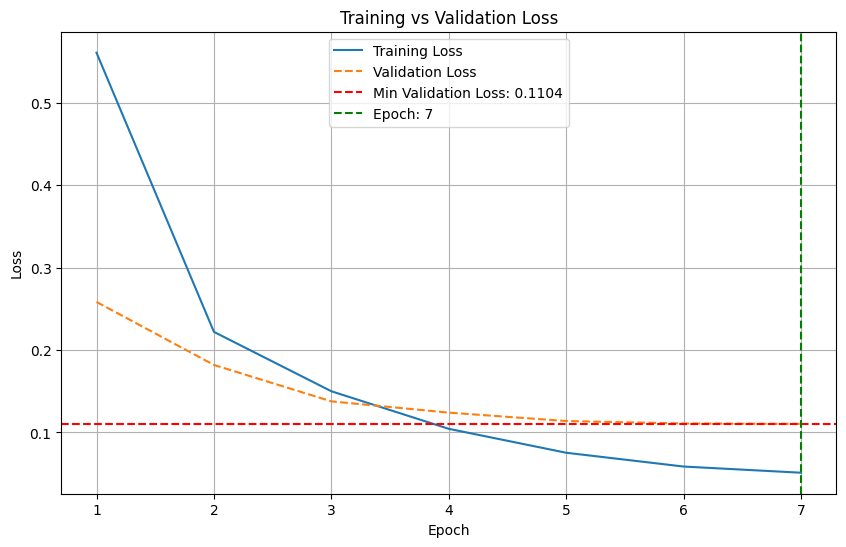

Macro-Averaged F1 Score: 0.3537

Micro-Averaged F1 Score: 0.6813

Weigthed-Averaged F1 Score: 0.6674

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     6         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8029     0.9244     0.8594     119       

I-Activity                          0.0000     0.0000     0.0000     9         

B-Activity Data                     0.7667     0.8000     0.7830     115       

I-Activity Data                     0.5586     0.7431     0.6378     109       

B-Actor                             0.8544     0.7652     0.8073     115       

I-Actor                             0.6574     0.6961     0.6762     102       

B-Condition Specification           0.5000     0.0588     0.1053     17        

I-Condition Specification           0.0476     0.0625     0.0541     16        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5737, Precision: 0.8777, Recall: 0.7113, F1: 0.7855
Step 50, Loss: 0.2468, Precision: 0.8513, Recall: 0.9135, F1: 0.8770
Average training loss: 0.5576

Macro-Averaged F1 Score: 0.0209

Micro-Averaged F1 Score: 0.0591

Weigthed-Averaged F1 Score: 0.0544

Epoch 2/7
Training...
Step 0, Loss: 0.2065, Precision: 0.8517, Recall: 0.9139, F1: 0.8783
Step 50, Loss: 0.1863, Precision: 0.9189, Recall: 0.9426, F1: 0.9302
Average training loss: 0.2176

Macro-Averaged F1 Score: 0.2334

Micro-Averaged F1 Score: 0.4825

Weigthed-Averaged F1 Score: 0.4580

Epoch 3/7
Training...
Step 0, Loss: 0.1873, Precision: 0.9191, Recall: 0.9426, F1: 0.9304
Step 50, Loss: 0.1012, Precision: 0.9435, Recall: 0.9537, F1: 0.9467
Average training loss: 0.1485

Macro-Averaged F1 Score: 0.3184

Micro-Averaged F1 Score: 0.6109

Weigthed-Averaged F1 Score: 0.5866

Epoch 4/7
Training...
Step 0, Loss: 0.1313, Precision: 0.9432, Recall: 0.9535, F1: 0.9461
Step 50, Loss: 0.0960, Precision: 

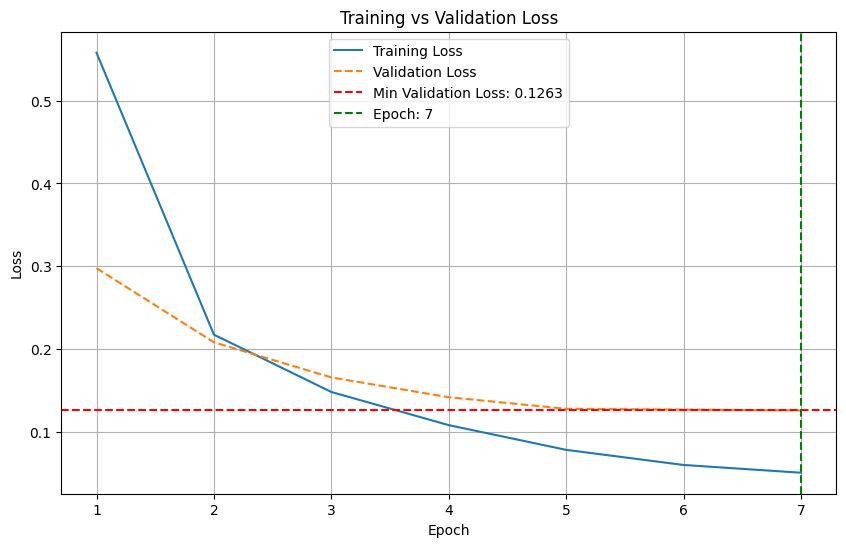

Macro-Averaged F1 Score: 0.3847

Micro-Averaged F1 Score: 0.6660

Weigthed-Averaged F1 Score: 0.6558

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.7801     0.8871     0.8302     124       

I-Activity                          0.0000     0.0000     0.0000     10        

B-Activity Data                     0.7023     0.8142     0.7541     113       

I-Activity Data                     0.4698     0.7071     0.5645     99        

B-Actor                             0.8700     0.8700     0.8700     100       

I-Actor                             0.7449     0.8488     0.7935     86        

B-Condition Specification           1.0000     0.1250     0.2222     24        

I-Condition Specification           0.0588     0.0833     0.0690     24        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5716, Precision: 0.8563, Recall: 0.7679, F1: 0.8037
Step 50, Loss: 0.3037, Precision: 0.8486, Recall: 0.9034, F1: 0.8645
Average training loss: 0.5775

Macro-Averaged F1 Score: 0.0332

Micro-Averaged F1 Score: 0.0813

Weigthed-Averaged F1 Score: 0.0695

Epoch 2/7
Training...
Step 0, Loss: 0.2444, Precision: 0.8488, Recall: 0.9031, F1: 0.8639
Step 50, Loss: 0.2067, Precision: 0.9196, Recall: 0.9343, F1: 0.9174
Average training loss: 0.2129

Macro-Averaged F1 Score: 0.1893

Micro-Averaged F1 Score: 0.4252

Weigthed-Averaged F1 Score: 0.4054

Epoch 3/7
Training...
Step 0, Loss: 0.1523, Precision: 0.9252, Recall: 0.9387, F1: 0.9243
Step 50, Loss: 0.0738, Precision: 0.9507, Recall: 0.9594, F1: 0.9543
Average training loss: 0.1447

Macro-Averaged F1 Score: 0.3177

Micro-Averaged F1 Score: 0.6228

Weigthed-Averaged F1 Score: 0.6103

Epoch 4/7
Training...
Step 0, Loss: 0.1834, Precision: 0.9515, Recall: 0.9597, F1: 0.9550
Step 50, Loss: 0.1067, Precision: 

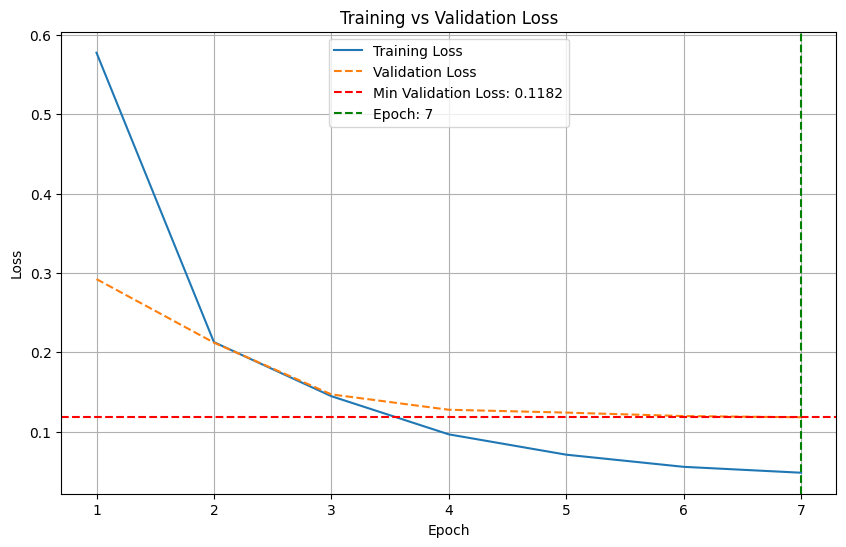

Macro-Averaged F1 Score: 0.4146

Micro-Averaged F1 Score: 0.7272

Weigthed-Averaged F1 Score: 0.7178

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.8601     0.8425     0.8512     146       

I-Activity                          0.0000     0.0000     0.0000     9         

B-Activity Data                     0.8538     0.8473     0.8506     131       

I-Activity Data                     0.5563     0.7607     0.6426     117       

B-Actor                             0.8519     0.8712     0.8614     132       

I-Actor                             0.7727     0.8947     0.8293     114       

B-Condition Specification           0.8571     0.2400     0.3750     25        

I-Condition Specification           0.2188     0.3043     0.2545     23        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8285, Precision: 0.8656, Recall: 0.2683, F1: 0.4083
Step 50, Loss: 0.3276, Precision: 0.8768, Recall: 0.9319, F1: 0.9026
Average training loss: 0.6055

Macro-Averaged F1 Score: 0.0116

Micro-Averaged F1 Score: 0.0532

Weigthed-Averaged F1 Score: 0.0428

Epoch 2/7
Training...
Step 0, Loss: 0.3481, Precision: 0.8774, Recall: 0.9322, F1: 0.9032
Step 50, Loss: 0.1642, Precision: 0.9495, Recall: 0.9574, F1: 0.9501
Average training loss: 0.2322

Macro-Averaged F1 Score: 0.2238

Micro-Averaged F1 Score: 0.4742

Weigthed-Averaged F1 Score: 0.4573

Epoch 3/7
Training...
Step 0, Loss: 0.1761, Precision: 0.9514, Recall: 0.9575, F1: 0.9507
Step 50, Loss: 0.1561, Precision: 0.9564, Recall: 0.9642, F1: 0.9595
Average training loss: 0.1488

Macro-Averaged F1 Score: 0.2918

Micro-Averaged F1 Score: 0.5646

Weigthed-Averaged F1 Score: 0.5507

Epoch 4/7
Training...
Step 0, Loss: 0.1286, Precision: 0.9583, Recall: 0.9650, F1: 0.9613
Step 50, Loss: 0.0924, Precision: 

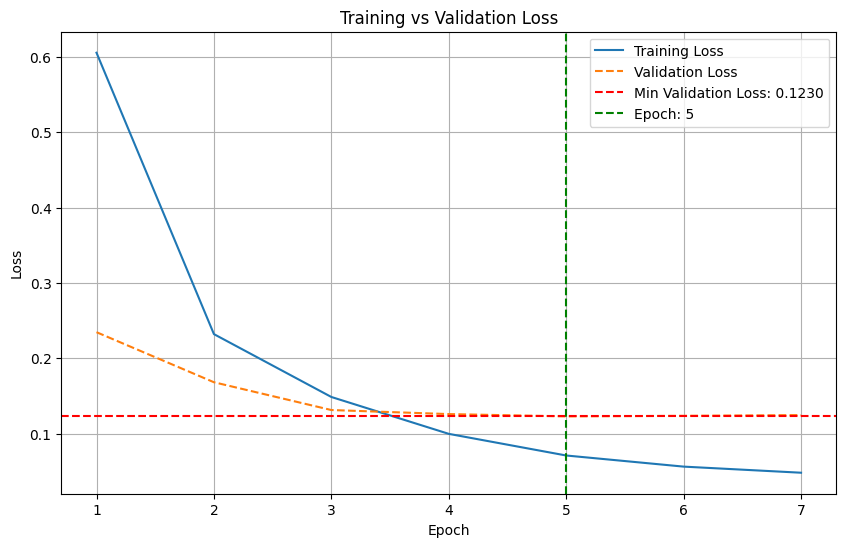

Macro-Averaged F1 Score: 0.3696

Micro-Averaged F1 Score: 0.6291

Weigthed-Averaged F1 Score: 0.6250

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     10        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.7748     0.8190     0.7963     105       

I-Activity                          0.0000     0.0000     0.0000     5         

B-Activity Data                     0.7474     0.7100     0.7282     100       

I-Activity Data                     0.5185     0.6292     0.5685     89        

B-Actor                             0.8191     0.7778     0.7979     99        

I-Actor                             0.7294     0.8378     0.7799     74        

B-Condition Specification           0.6364     0.3182     0.4242     22        

I-Condition Specification           0.1765     0.2727     0.2143     22        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7638, Precision: 0.8535, Recall: 0.3185, F1: 0.4592
Step 50, Loss: 0.1723, Precision: 0.8642, Recall: 0.9202, F1: 0.8869
Average training loss: 0.4819

Macro-Averaged F1 Score: 0.0508

Micro-Averaged F1 Score: 0.1717

Weigthed-Averaged F1 Score: 0.1143

Epoch 2/7
Training...
Step 0, Loss: 0.2521, Precision: 0.8811, Recall: 0.9206, F1: 0.8882
Step 50, Loss: 0.1121, Precision: 0.9398, Recall: 0.9534, F1: 0.9459
Average training loss: 0.1927

Macro-Averaged F1 Score: 0.3033

Micro-Averaged F1 Score: 0.5600

Weigthed-Averaged F1 Score: 0.5366

Epoch 3/7
Training...
Step 0, Loss: 0.2055, Precision: 0.9399, Recall: 0.9547, F1: 0.9467
Step 50, Loss: 0.1943, Precision: 0.9458, Recall: 0.9629, F1: 0.9541
Average training loss: 0.1139

Macro-Averaged F1 Score: 0.4120

Micro-Averaged F1 Score: 0.6435

Weigthed-Averaged F1 Score: 0.6124

Epoch 4/7
Training...
Step 0, Loss: 0.0735, Precision: 0.9456, Recall: 0.9623, F1: 0.9537
Step 50, Loss: 0.0939, Precision: 

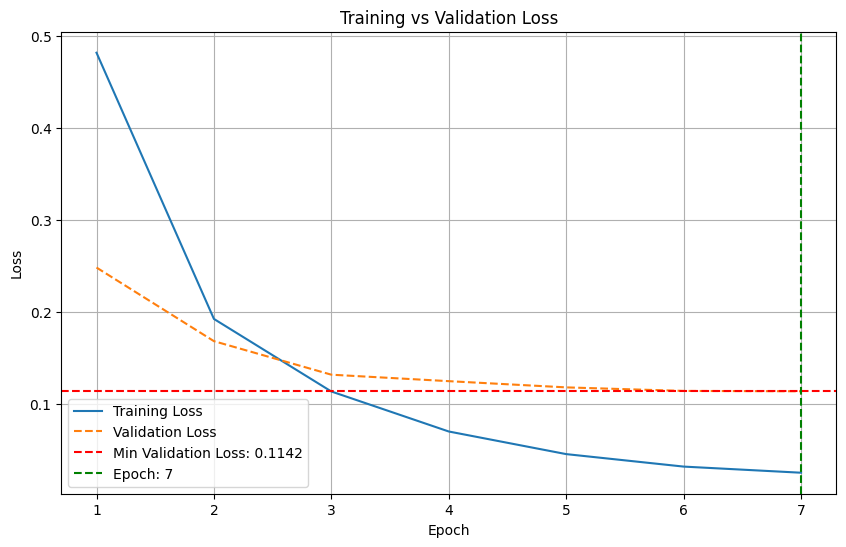

Macro-Averaged F1 Score: 0.4814

Micro-Averaged F1 Score: 0.6931

Weigthed-Averaged F1 Score: 0.6726

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     10        

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8433     0.9496     0.8933     119       

I-Activity                          1.0000     0.1818     0.3077     11        

B-Activity Data                     0.7928     0.8073     0.8000     109       

I-Activity Data                     0.5512     0.7000     0.6167     100       

B-Actor                             0.8713     0.9167     0.8934     96        

I-Actor                             0.7609     0.8537     0.8046     82        

B-Condition Specification           0.7000     0.7000     0.7000     10        

I-Condition Specification           0.7000     0.7000     0.7000     10        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5084, Precision: 0.8896, Recall: 0.8483, F1: 0.8664
Step 50, Loss: 0.1865, Precision: 0.9017, Recall: 0.9324, F1: 0.9094
Average training loss: 0.4498

Macro-Averaged F1 Score: 0.0987

Micro-Averaged F1 Score: 0.2061

Weigthed-Averaged F1 Score: 0.1950

Epoch 2/7
Training...
Step 0, Loss: 0.2314, Precision: 0.9119, Recall: 0.9320, F1: 0.9085
Step 50, Loss: 0.1865, Precision: 0.9560, Recall: 0.9649, F1: 0.9601
Average training loss: 0.1697

Macro-Averaged F1 Score: 0.3157

Micro-Averaged F1 Score: 0.6309

Weigthed-Averaged F1 Score: 0.6160

Epoch 3/7
Training...
Step 0, Loss: 0.1136, Precision: 0.9558, Recall: 0.9649, F1: 0.9600
Step 50, Loss: 0.0702, Precision: 0.9629, Recall: 0.9700, F1: 0.9657
Average training loss: 0.0959

Macro-Averaged F1 Score: 0.3499

Micro-Averaged F1 Score: 0.7011

Weigthed-Averaged F1 Score: 0.6803

Epoch 4/7
Training...
Step 0, Loss: 0.0789, Precision: 0.9630, Recall: 0.9701, F1: 0.9657
Step 50, Loss: 0.0602, Precision: 

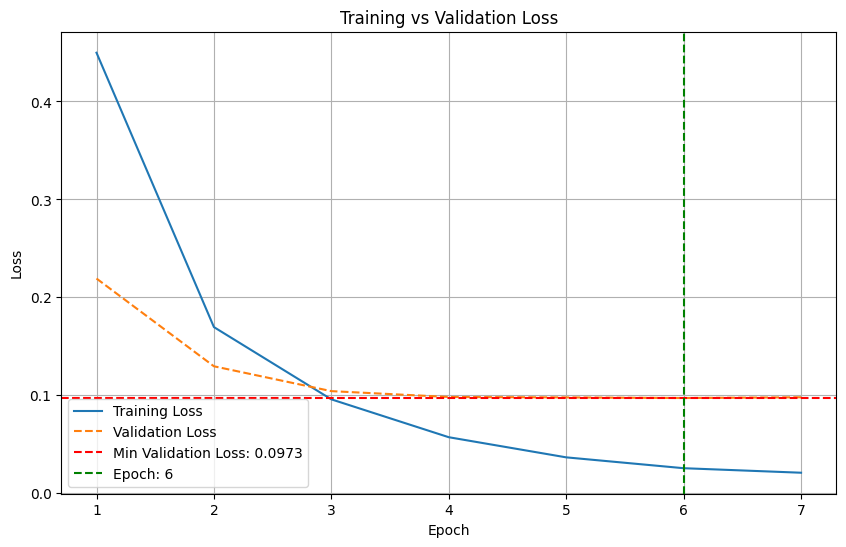

Macro-Averaged F1 Score: 0.5090

Micro-Averaged F1 Score: 0.7396

Weigthed-Averaged F1 Score: 0.7334

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     6         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8162     0.9328     0.8706     119       

I-Activity                          0.8000     0.4444     0.5714     9         

B-Activity Data                     0.8142     0.8000     0.8070     115       

I-Activity Data                     0.6031     0.7248     0.6583     109       

B-Actor                             0.8868     0.8174     0.8507     115       

I-Actor                             0.7596     0.7745     0.7670     102       

B-Condition Specification           1.0000     0.6471     0.7857     17        

I-Condition Specification           0.3913     0.5625     0.4615     16        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7535, Precision: 0.8778, Recall: 0.4097, F1: 0.5538
Step 50, Loss: 0.2239, Precision: 0.9102, Recall: 0.9319, F1: 0.9187
Average training loss: 0.4807

Macro-Averaged F1 Score: 0.1684

Micro-Averaged F1 Score: 0.3437

Weigthed-Averaged F1 Score: 0.3296

Epoch 2/7
Training...
Step 0, Loss: 0.1961, Precision: 0.9110, Recall: 0.9323, F1: 0.9195
Step 50, Loss: 0.1295, Precision: 0.9436, Recall: 0.9584, F1: 0.9501
Average training loss: 0.1668

Macro-Averaged F1 Score: 0.3284

Micro-Averaged F1 Score: 0.5998

Weigthed-Averaged F1 Score: 0.5902

Epoch 3/7
Training...
Step 0, Loss: 0.0972, Precision: 0.9455, Recall: 0.9599, F1: 0.9522
Step 50, Loss: 0.1190, Precision: 0.9596, Recall: 0.9631, F1: 0.9578
Average training loss: 0.0999

Macro-Averaged F1 Score: 0.3833

Micro-Averaged F1 Score: 0.6720

Weigthed-Averaged F1 Score: 0.6573

Epoch 4/7
Training...
Step 0, Loss: 0.0830, Precision: 0.9579, Recall: 0.9607, F1: 0.9565
Step 50, Loss: 0.0167, Precision: 

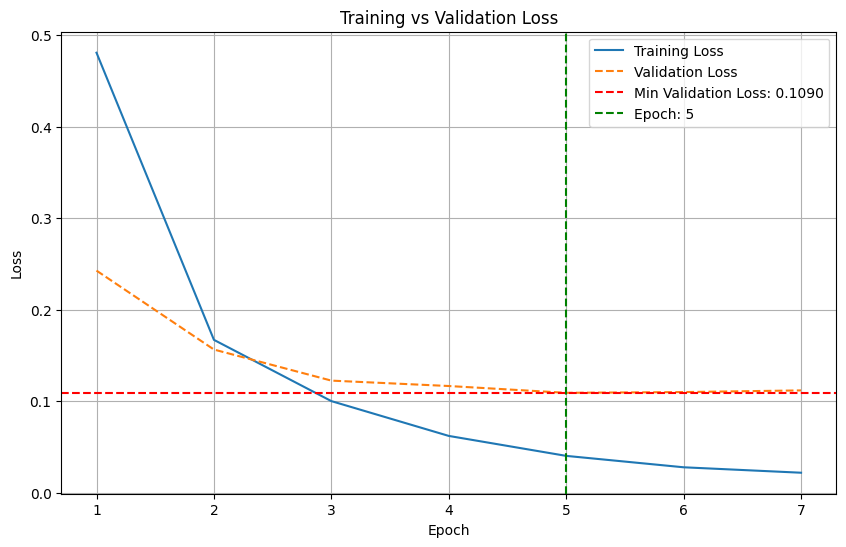

Macro-Averaged F1 Score: 0.4999

Micro-Averaged F1 Score: 0.7115

Weigthed-Averaged F1 Score: 0.7069

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.7958     0.9113     0.8496     124       

I-Activity                          1.0000     0.2000     0.3333     10        

B-Activity Data                     0.7686     0.8230     0.7949     113       

I-Activity Data                     0.5606     0.7475     0.6407     99        

B-Actor                             0.8878     0.8700     0.8788     100       

I-Actor                             0.7059     0.8372     0.7660     86        

B-Condition Specification           0.6538     0.7083     0.6800     24        

I-Condition Specification           0.4857     0.7083     0.5763     24        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.9083, Precision: 0.8232, Recall: 0.2065, F1: 0.3259
Step 50, Loss: 0.2263, Precision: 0.7989, Recall: 0.8938, F1: 0.8437
Average training loss: 0.5057

Macro-Averaged F1 Score: 0.0015

Micro-Averaged F1 Score: 0.0082

Weigthed-Averaged F1 Score: 0.0069

Epoch 2/7
Training...
Step 0, Loss: 0.2598, Precision: 0.7989, Recall: 0.8938, F1: 0.8437
Step 50, Loss: 0.1379, Precision: 0.9434, Recall: 0.9522, F1: 0.9452
Average training loss: 0.2075

Macro-Averaged F1 Score: 0.2979

Micro-Averaged F1 Score: 0.5792

Weigthed-Averaged F1 Score: 0.5686

Epoch 3/7
Training...
Step 0, Loss: 0.1747, Precision: 0.9444, Recall: 0.9530, F1: 0.9463
Step 50, Loss: 0.1391, Precision: 0.9586, Recall: 0.9656, F1: 0.9609
Average training loss: 0.1257

Macro-Averaged F1 Score: 0.3596

Micro-Averaged F1 Score: 0.6891

Weigthed-Averaged F1 Score: 0.6740

Epoch 4/7
Training...
Step 0, Loss: 0.0778, Precision: 0.9599, Recall: 0.9663, F1: 0.9619
Step 50, Loss: 0.0618, Precision: 

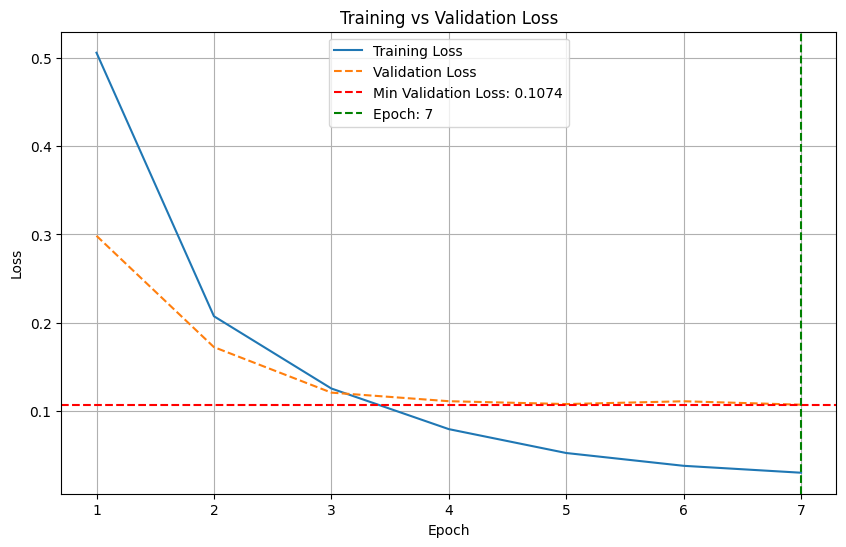

Macro-Averaged F1 Score: 0.4763

Micro-Averaged F1 Score: 0.7589

Weigthed-Averaged F1 Score: 0.7533

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.8741     0.8562     0.8651     146       

I-Activity                          0.0000     0.0000     0.0000     9         

B-Activity Data                     0.8467     0.8855     0.8657     131       

I-Activity Data                     0.6496     0.7607     0.7008     117       

B-Actor                             0.8731     0.8864     0.8797     132       

I-Actor                             0.8095     0.8947     0.8500     114       

B-Condition Specification           0.8462     0.4400     0.5789     25        

I-Condition Specification           0.3226     0.4348     0.3704     23        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7146, Precision: 0.9094, Recall: 0.7417, F1: 0.8170
Step 50, Loss: 0.2654, Precision: 0.9308, Recall: 0.9453, F1: 0.9300
Average training loss: 0.4893

Macro-Averaged F1 Score: 0.1143

Micro-Averaged F1 Score: 0.2757

Weigthed-Averaged F1 Score: 0.2443

Epoch 2/7
Training...
Step 0, Loss: 0.2119, Precision: 0.9295, Recall: 0.9463, F1: 0.9320
Step 50, Loss: 0.1322, Precision: 0.9566, Recall: 0.9647, F1: 0.9594
Average training loss: 0.1848

Macro-Averaged F1 Score: 0.3145

Micro-Averaged F1 Score: 0.6008

Weigthed-Averaged F1 Score: 0.5815

Epoch 3/7
Training...
Step 0, Loss: 0.1080, Precision: 0.9555, Recall: 0.9640, F1: 0.9583
Step 50, Loss: 0.0965, Precision: 0.9615, Recall: 0.9653, F1: 0.9630
Average training loss: 0.1047

Macro-Averaged F1 Score: 0.3299

Micro-Averaged F1 Score: 0.6299

Weigthed-Averaged F1 Score: 0.6167

Epoch 4/7
Training...
Step 0, Loss: 0.0959, Precision: 0.9639, Recall: 0.9657, F1: 0.9637
Step 50, Loss: 0.0322, Precision: 

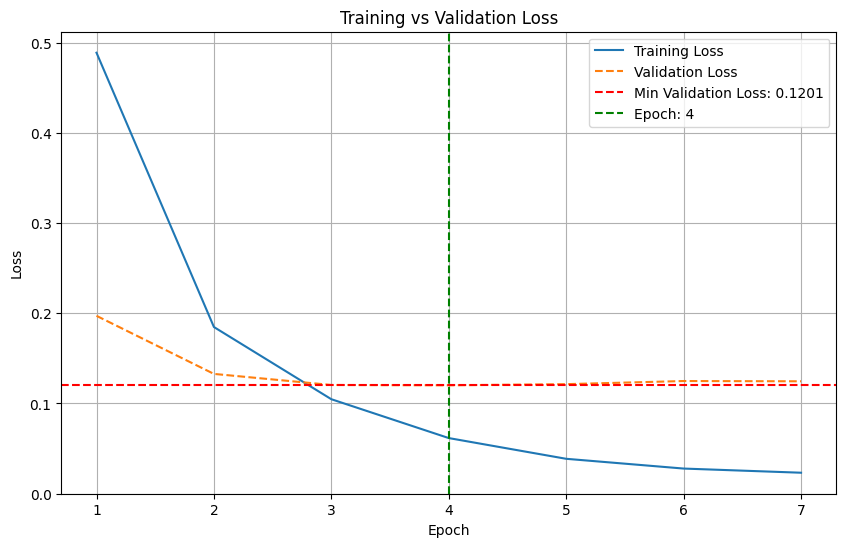

Macro-Averaged F1 Score: 0.4005

Micro-Averaged F1 Score: 0.6685

Weigthed-Averaged F1 Score: 0.6599

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     10        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.7500     0.8286     0.7873     105       

I-Activity                          0.0000     0.0000     0.0000     5         

B-Activity Data                     0.7103     0.7600     0.7343     100       

I-Activity Data                     0.5941     0.6742     0.6316     89        

B-Actor                             0.8280     0.7778     0.8021     99        

I-Actor                             0.7403     0.7703     0.7550     74        

B-Condition Specification           0.6111     0.5000     0.5500     22        

I-Condition Specification           0.3448     0.4545     0.3922     22        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7953, Precision: 0.8725, Recall: 0.7234, F1: 0.7904
Step 50, Loss: 0.2433, Precision: 0.9302, Recall: 0.9390, F1: 0.9304
Average training loss: 0.4682

Macro-Averaged F1 Score: 0.1857

Micro-Averaged F1 Score: 0.3906

Weigthed-Averaged F1 Score: 0.3879

Epoch 2/7
Training...
Step 0, Loss: 0.2849, Precision: 0.9271, Recall: 0.9409, F1: 0.9307
Step 50, Loss: 0.1761, Precision: 0.9415, Recall: 0.9604, F1: 0.9506
Average training loss: 0.1459

Macro-Averaged F1 Score: 0.3277

Micro-Averaged F1 Score: 0.6000

Weigthed-Averaged F1 Score: 0.5710

Epoch 3/7
Training...
Step 0, Loss: 0.1107, Precision: 0.9421, Recall: 0.9608, F1: 0.9511
Step 50, Loss: 0.2058, Precision: 0.9526, Recall: 0.9638, F1: 0.9555
Average training loss: 0.0817

Macro-Averaged F1 Score: 0.4191

Micro-Averaged F1 Score: 0.6592

Weigthed-Averaged F1 Score: 0.6338

Epoch 4/7
Training...
Step 0, Loss: 0.0244, Precision: 0.9541, Recall: 0.9647, F1: 0.9574
Step 50, Loss: 0.0144, Precision: 

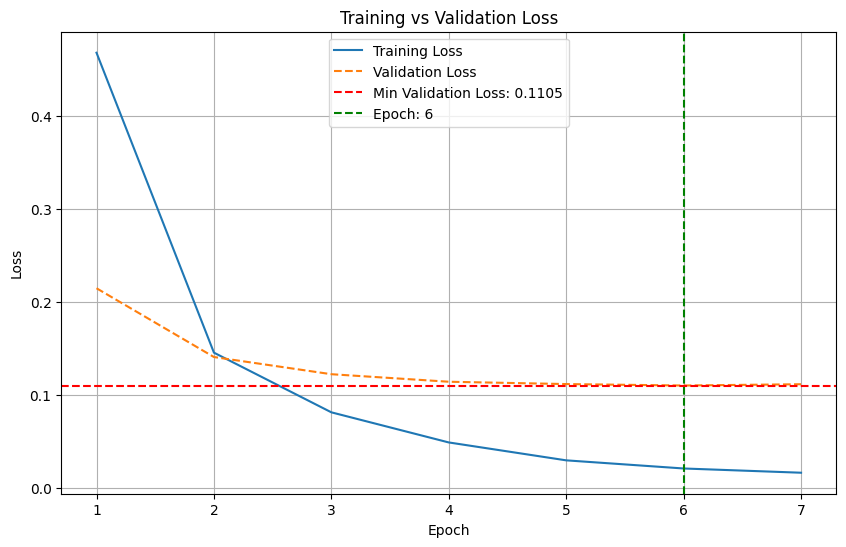

Macro-Averaged F1 Score: 0.5192

Micro-Averaged F1 Score: 0.7031

Weigthed-Averaged F1 Score: 0.6927

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     10        

I-AND Gateway                       0.3333     0.2500     0.2857     4         

B-Activity                          0.8571     0.9580     0.9048     119       

I-Activity                          1.0000     0.1818     0.3077     11        

B-Activity Data                     0.8182     0.8257     0.8219     109       

I-Activity Data                     0.5308     0.6900     0.6000     100       

B-Actor                             0.8411     0.9375     0.8867     96        

I-Actor                             0.6667     0.8537     0.7487     82        

B-Condition Specification           0.8571     0.6000     0.7059     10        

I-Condition Specification           0.6667     0.6000     0.6316     10        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6971, Precision: 0.8516, Recall: 0.8217, F1: 0.8361
Step 50, Loss: 0.1757, Precision: 0.9354, Recall: 0.9476, F1: 0.9404
Average training loss: 0.4307

Macro-Averaged F1 Score: 0.2213

Micro-Averaged F1 Score: 0.4714

Weigthed-Averaged F1 Score: 0.4588

Epoch 2/7
Training...
Step 0, Loss: 0.2141, Precision: 0.9361, Recall: 0.9470, F1: 0.9401
Step 50, Loss: 0.1488, Precision: 0.9595, Recall: 0.9664, F1: 0.9621
Average training loss: 0.1561

Macro-Averaged F1 Score: 0.3413

Micro-Averaged F1 Score: 0.6673

Weigthed-Averaged F1 Score: 0.6482

Epoch 3/7
Training...
Step 0, Loss: 0.0926, Precision: 0.9591, Recall: 0.9668, F1: 0.9622
Step 50, Loss: 0.0757, Precision: 0.9612, Recall: 0.9674, F1: 0.9635
Average training loss: 0.0856

Macro-Averaged F1 Score: 0.4009

Micro-Averaged F1 Score: 0.6736

Weigthed-Averaged F1 Score: 0.6625

Epoch 4/7
Training...
Step 0, Loss: 0.0842, Precision: 0.9628, Recall: 0.9677, F1: 0.9647
Step 50, Loss: 0.0599, Precision: 

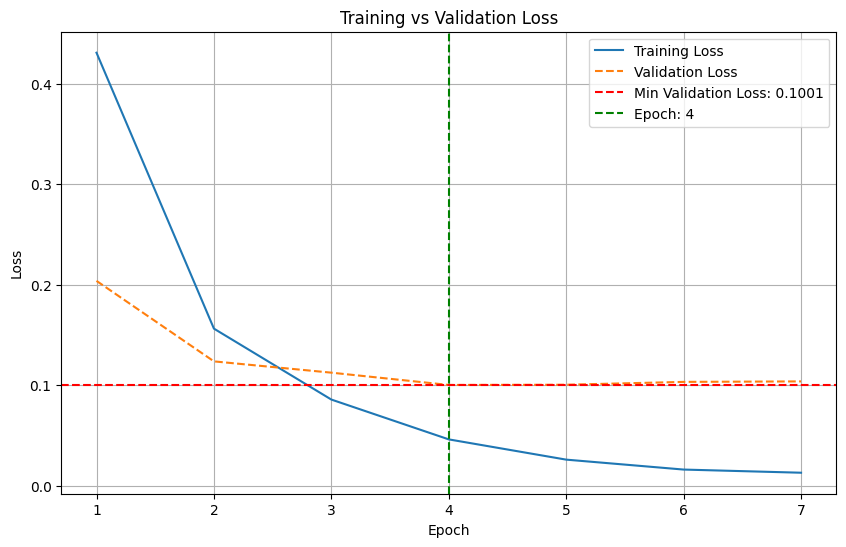

Macro-Averaged F1 Score: 0.5742

Micro-Averaged F1 Score: 0.7574

Weigthed-Averaged F1 Score: 0.7558

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     6         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8370     0.9496     0.8898     119       

I-Activity                          1.0000     0.7778     0.8750     9         

B-Activity Data                     0.8547     0.8696     0.8621     115       

I-Activity Data                     0.6720     0.7706     0.7179     109       

B-Actor                             0.9167     0.8609     0.8879     115       

I-Actor                             0.7664     0.8039     0.7847     102       

B-Condition Specification           0.9167     0.6471     0.7586     17        

I-Condition Specification           0.4091     0.5625     0.4737     16        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7396, Precision: 0.8412, Recall: 0.7394, F1: 0.7861
Step 50, Loss: 0.2715, Precision: 0.9098, Recall: 0.9202, F1: 0.9039
Average training loss: 0.4554

Macro-Averaged F1 Score: 0.0514

Micro-Averaged F1 Score: 0.1997

Weigthed-Averaged F1 Score: 0.1687

Epoch 2/7
Training...
Step 0, Loss: 0.2794, Precision: 0.9152, Recall: 0.9213, F1: 0.9078
Step 50, Loss: 0.0644, Precision: 0.9486, Recall: 0.9547, F1: 0.9499
Average training loss: 0.1751

Macro-Averaged F1 Score: 0.3017

Micro-Averaged F1 Score: 0.6027

Weigthed-Averaged F1 Score: 0.5818

Epoch 3/7
Training...
Step 0, Loss: 0.2126, Precision: 0.9482, Recall: 0.9472, F1: 0.9448
Step 50, Loss: 0.1088, Precision: 0.9579, Recall: 0.9609, F1: 0.9583
Average training loss: 0.0919

Macro-Averaged F1 Score: 0.3943

Micro-Averaged F1 Score: 0.6679

Weigthed-Averaged F1 Score: 0.6641

Epoch 4/7
Training...
Step 0, Loss: 0.1481, Precision: 0.9578, Recall: 0.9615, F1: 0.9587
Step 50, Loss: 0.0263, Precision: 

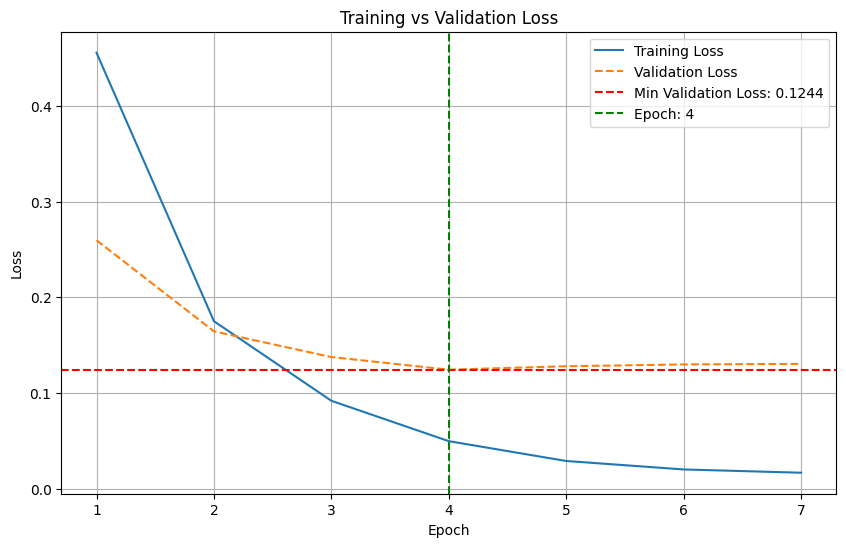

Macro-Averaged F1 Score: 0.5025

Micro-Averaged F1 Score: 0.7092

Weigthed-Averaged F1 Score: 0.7082

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8058     0.9032     0.8517     124       

I-Activity                          1.0000     0.2000     0.3333     10        

B-Activity Data                     0.7760     0.8584     0.8151     113       

I-Activity Data                     0.4713     0.7475     0.5781     99        

B-Actor                             0.8190     0.8600     0.8390     100       

I-Actor                             0.7955     0.8140     0.8046     86        

B-Condition Specification           0.9375     0.6250     0.7500     24        

I-Condition Specification           0.6250     0.6250     0.6250     24        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8056, Precision: 0.8040, Recall: 0.5748, F1: 0.6695
Step 50, Loss: 0.1774, Precision: 0.9181, Recall: 0.9386, F1: 0.9273
Average training loss: 0.4752

Macro-Averaged F1 Score: 0.2519

Micro-Averaged F1 Score: 0.4994

Weigthed-Averaged F1 Score: 0.4853

Epoch 2/7
Training...
Step 0, Loss: 0.2247, Precision: 0.9159, Recall: 0.9372, F1: 0.9252
Step 50, Loss: 0.1592, Precision: 0.9538, Recall: 0.9628, F1: 0.9577
Average training loss: 0.1520

Macro-Averaged F1 Score: 0.3385

Micro-Averaged F1 Score: 0.6577

Weigthed-Averaged F1 Score: 0.6451

Epoch 3/7
Training...
Step 0, Loss: 0.0969, Precision: 0.9540, Recall: 0.9631, F1: 0.9580
Step 50, Loss: 0.0442, Precision: 0.9669, Recall: 0.9693, F1: 0.9671
Average training loss: 0.0848

Macro-Averaged F1 Score: 0.4326

Micro-Averaged F1 Score: 0.7387

Weigthed-Averaged F1 Score: 0.7293

Epoch 4/7
Training...
Step 0, Loss: 0.0820, Precision: 0.9670, Recall: 0.9695, F1: 0.9673
Step 50, Loss: 0.0548, Precision: 

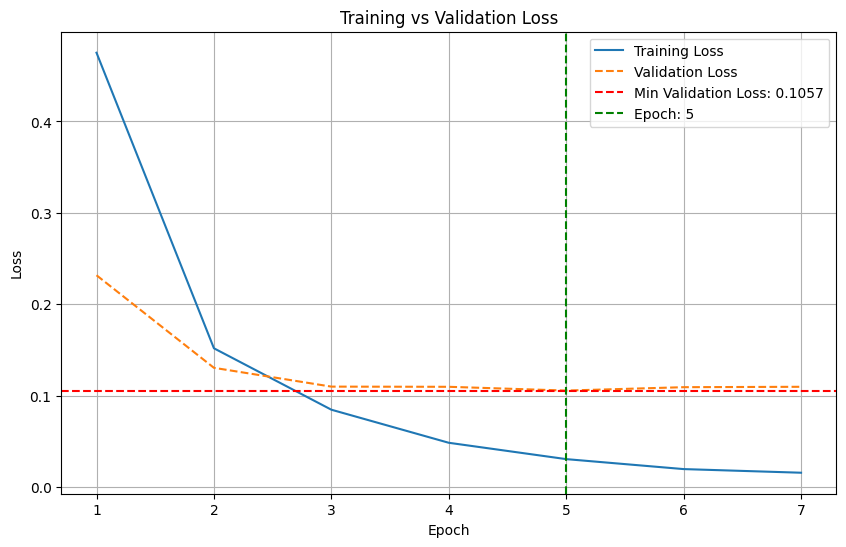

Macro-Averaged F1 Score: 0.5296

Micro-Averaged F1 Score: 0.7696

Weigthed-Averaged F1 Score: 0.7673

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.8681     0.8562     0.8621     146       

I-Activity                          0.8000     0.4444     0.5714     9         

B-Activity Data                     0.8345     0.8855     0.8593     131       

I-Activity Data                     0.5986     0.7521     0.6667     117       

B-Actor                             0.8855     0.8788     0.8821     132       

I-Actor                             0.8031     0.8947     0.8465     114       

B-Condition Specification           0.8125     0.5200     0.6341     25        

I-Condition Specification           0.4000     0.4348     0.4167     23        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7850, Precision: 0.9014, Recall: 0.7597, F1: 0.8240
Step 50, Loss: 0.2105, Precision: 0.9377, Recall: 0.9500, F1: 0.9370
Average training loss: 0.4523

Macro-Averaged F1 Score: 0.1865

Micro-Averaged F1 Score: 0.3741

Weigthed-Averaged F1 Score: 0.3607

Epoch 2/7
Training...
Step 0, Loss: 0.2235, Precision: 0.9388, Recall: 0.9510, F1: 0.9385
Step 50, Loss: 0.1017, Precision: 0.9598, Recall: 0.9662, F1: 0.9628
Average training loss: 0.1492

Macro-Averaged F1 Score: 0.3216

Micro-Averaged F1 Score: 0.6137

Weigthed-Averaged F1 Score: 0.6005

Epoch 3/7
Training...
Step 0, Loss: 0.1492, Precision: 0.9601, Recall: 0.9668, F1: 0.9632
Step 50, Loss: 0.0461, Precision: 0.9642, Recall: 0.9672, F1: 0.9653
Average training loss: 0.0779

Macro-Averaged F1 Score: 0.3859

Micro-Averaged F1 Score: 0.6648

Weigthed-Averaged F1 Score: 0.6560

Epoch 4/7
Training...
Step 0, Loss: 0.0998, Precision: 0.9651, Recall: 0.9669, F1: 0.9655
Step 50, Loss: 0.0346, Precision: 

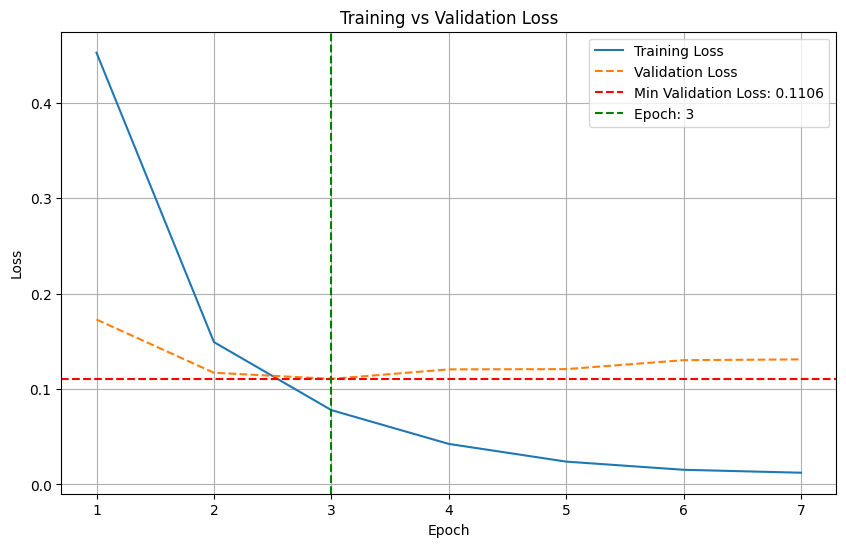

Macro-Averaged F1 Score: 0.4685

Micro-Averaged F1 Score: 0.6805

Weigthed-Averaged F1 Score: 0.6784

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.1000     0.1818     10        

I-AND Gateway                       0.5000     0.1667     0.2500     6         

B-Activity                          0.7672     0.8476     0.8054     105       

I-Activity                          0.3333     0.2000     0.2500     5         

B-Activity Data                     0.7207     0.8000     0.7583     100       

I-Activity Data                     0.6354     0.6854     0.6595     89        

B-Actor                             0.8667     0.7879     0.8254     99        

I-Actor                             0.7368     0.7568     0.7467     74        

B-Condition Specification           0.6667     0.6364     0.6512     22        

I-Condition Specification           0.4815     0.5909     0.5306     22        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5486, Precision: 0.8538, Recall: 0.8868, F1: 0.8695
Step 50, Loss: 0.2137, Precision: 0.9370, Recall: 0.9518, F1: 0.9432
Average training loss: 0.3662

Macro-Averaged F1 Score: 0.2797

Micro-Averaged F1 Score: 0.5099

Weigthed-Averaged F1 Score: 0.4997

Epoch 2/7
Training...
Step 0, Loss: 0.2358, Precision: 0.9352, Recall: 0.9521, F1: 0.9425
Step 50, Loss: 0.0851, Precision: 0.9468, Recall: 0.9640, F1: 0.9550
Average training loss: 0.1183

Macro-Averaged F1 Score: 0.3852

Micro-Averaged F1 Score: 0.6560

Weigthed-Averaged F1 Score: 0.6263

Epoch 3/7
Training...
Step 0, Loss: 0.1084, Precision: 0.9467, Recall: 0.9645, F1: 0.9554
Step 50, Loss: 0.0844, Precision: 0.9613, Recall: 0.9636, F1: 0.9591
Average training loss: 0.0625

Macro-Averaged F1 Score: 0.4259

Micro-Averaged F1 Score: 0.6654

Weigthed-Averaged F1 Score: 0.6429

Epoch 4/7
Training...
Step 0, Loss: 0.0826, Precision: 0.9612, Recall: 0.9635, F1: 0.9592
Step 50, Loss: 0.0384, Precision: 

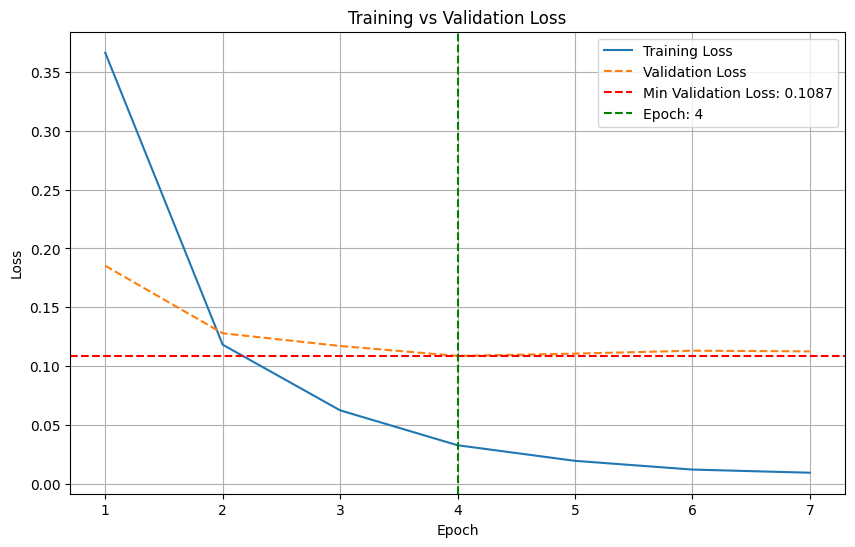

Macro-Averaged F1 Score: 0.5688

Micro-Averaged F1 Score: 0.7234

Weigthed-Averaged F1 Score: 0.7130

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.1000     0.1818     10        

I-AND Gateway                       0.5000     0.2500     0.3333     4         

B-Activity                          0.8582     0.9664     0.9091     119       

I-Activity                          0.7500     0.2727     0.4000     11        

B-Activity Data                     0.7949     0.8532     0.8230     109       

I-Activity Data                     0.5846     0.7600     0.6609     100       

B-Actor                             0.8349     0.9479     0.8878     96        

I-Actor                             0.7158     0.8293     0.7684     82        

B-Condition Specification           0.8750     0.7000     0.7778     10        

I-Condition Specification           0.7778     0.7000     0.7368     10        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8246, Precision: 0.8674, Recall: 0.7721, F1: 0.8155
Step 50, Loss: 0.2203, Precision: 0.9470, Recall: 0.9545, F1: 0.9466
Average training loss: 0.3841

Macro-Averaged F1 Score: 0.2478

Micro-Averaged F1 Score: 0.5402

Weigthed-Averaged F1 Score: 0.5176

Epoch 2/7
Training...
Step 0, Loss: 0.2412, Precision: 0.9482, Recall: 0.9557, F1: 0.9480
Step 50, Loss: 0.0593, Precision: 0.9614, Recall: 0.9678, F1: 0.9629
Average training loss: 0.1289

Macro-Averaged F1 Score: 0.3855

Micro-Averaged F1 Score: 0.6807

Weigthed-Averaged F1 Score: 0.6659

Epoch 3/7
Training...
Step 0, Loss: 0.1375, Precision: 0.9621, Recall: 0.9675, F1: 0.9632
Step 50, Loss: 0.0252, Precision: 0.9666, Recall: 0.9707, F1: 0.9678
Average training loss: 0.0711

Macro-Averaged F1 Score: 0.4467

Micro-Averaged F1 Score: 0.7147

Weigthed-Averaged F1 Score: 0.7046

Epoch 4/7
Training...
Step 0, Loss: 0.0614, Precision: 0.9668, Recall: 0.9706, F1: 0.9675
Step 50, Loss: 0.0358, Precision: 

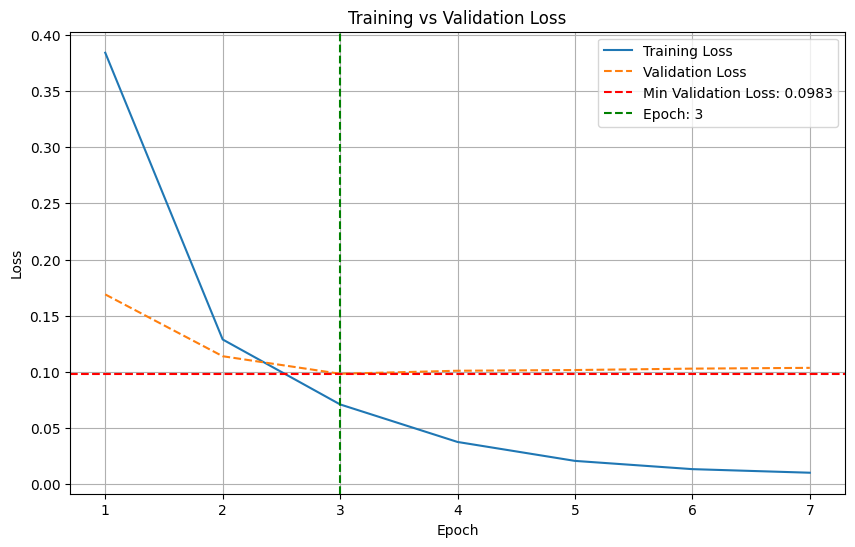

Macro-Averaged F1 Score: 0.5695

Micro-Averaged F1 Score: 0.7553

Weigthed-Averaged F1 Score: 0.7521

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     6         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8308     0.9076     0.8675     119       

I-Activity                          1.0000     0.6667     0.8000     9         

B-Activity Data                     0.8291     0.8435     0.8362     115       

I-Activity Data                     0.6452     0.7339     0.6867     109       

B-Actor                             0.9273     0.8870     0.9067     115       

I-Actor                             0.8095     0.8333     0.8213     102       

B-Condition Specification           0.9412     0.9412     0.9412     17        

I-Condition Specification           0.4800     0.7500     0.5854     16        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6048, Precision: 0.8330, Recall: 0.8886, F1: 0.8598
Step 50, Loss: 0.1972, Precision: 0.9427, Recall: 0.9403, F1: 0.9344
Average training loss: 0.3550

Macro-Averaged F1 Score: 0.2527

Micro-Averaged F1 Score: 0.5589

Weigthed-Averaged F1 Score: 0.5302

Epoch 2/7
Training...
Step 0, Loss: 0.1631, Precision: 0.9422, Recall: 0.9421, F1: 0.9354
Step 50, Loss: 0.1138, Precision: 0.9604, Recall: 0.9622, F1: 0.9593
Average training loss: 0.1176

Macro-Averaged F1 Score: 0.4169

Micro-Averaged F1 Score: 0.6798

Weigthed-Averaged F1 Score: 0.6673

Epoch 3/7
Training...
Step 0, Loss: 0.0748, Precision: 0.9611, Recall: 0.9611, F1: 0.9587
Step 50, Loss: 0.0556, Precision: 0.9634, Recall: 0.9646, F1: 0.9618
Average training loss: 0.0631

Macro-Averaged F1 Score: 0.4683

Micro-Averaged F1 Score: 0.7165

Weigthed-Averaged F1 Score: 0.7093

Epoch 4/7
Training...
Step 0, Loss: 0.0659, Precision: 0.9633, Recall: 0.9649, F1: 0.9617
Step 50, Loss: 0.0464, Precision: 

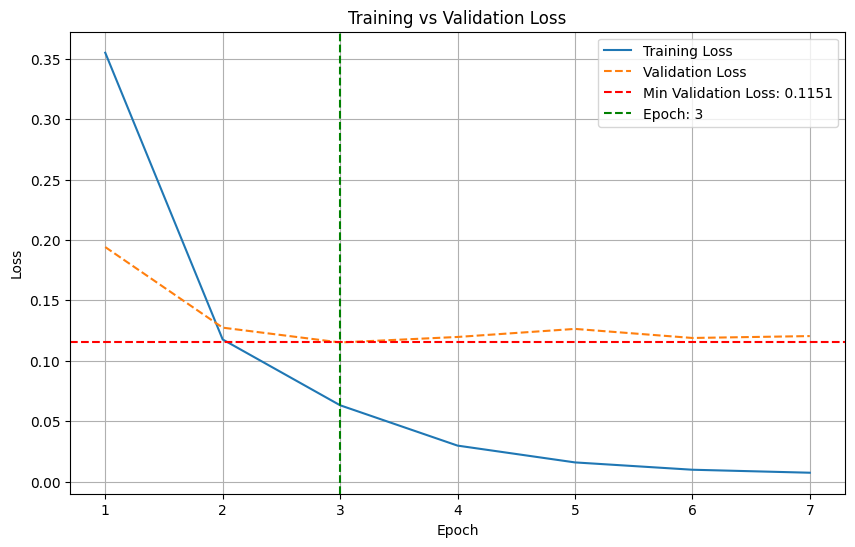

Macro-Averaged F1 Score: 0.6193

Micro-Averaged F1 Score: 0.7632

Weigthed-Averaged F1 Score: 0.7636

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8647     0.9274     0.8949     124       

I-Activity                          0.8571     0.6000     0.7059     10        

B-Activity Data                     0.8017     0.8584     0.8291     113       

I-Activity Data                     0.6333     0.7677     0.6941     99        

B-Actor                             0.8381     0.8800     0.8585     100       

I-Actor                             0.7935     0.8488     0.8202     86        

B-Condition Specification           0.8182     0.7500     0.7826     24        

I-Condition Specification           0.6538     0.7083     0.6800     24        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6481, Precision: 0.8168, Recall: 0.8552, F1: 0.8305
Step 50, Loss: 0.2063, Precision: 0.9196, Recall: 0.9428, F1: 0.9307
Average training loss: 0.3741

Macro-Averaged F1 Score: 0.2357

Micro-Averaged F1 Score: 0.5095

Weigthed-Averaged F1 Score: 0.4930

Epoch 2/7
Training...
Step 0, Loss: 0.1957, Precision: 0.9218, Recall: 0.9429, F1: 0.9304
Step 50, Loss: 0.0887, Precision: 0.9620, Recall: 0.9657, F1: 0.9608
Average training loss: 0.1299

Macro-Averaged F1 Score: 0.3948

Micro-Averaged F1 Score: 0.6999

Weigthed-Averaged F1 Score: 0.6835

Epoch 3/7
Training...
Step 0, Loss: 0.1068, Precision: 0.9638, Recall: 0.9676, F1: 0.9633
Step 50, Loss: 0.0372, Precision: 0.9660, Recall: 0.9686, F1: 0.9662
Average training loss: 0.0654

Macro-Averaged F1 Score: 0.4718

Micro-Averaged F1 Score: 0.7465

Weigthed-Averaged F1 Score: 0.7383

Epoch 4/7
Training...
Step 0, Loss: 0.0498, Precision: 0.9663, Recall: 0.9688, F1: 0.9663
Step 50, Loss: 0.0078, Precision: 

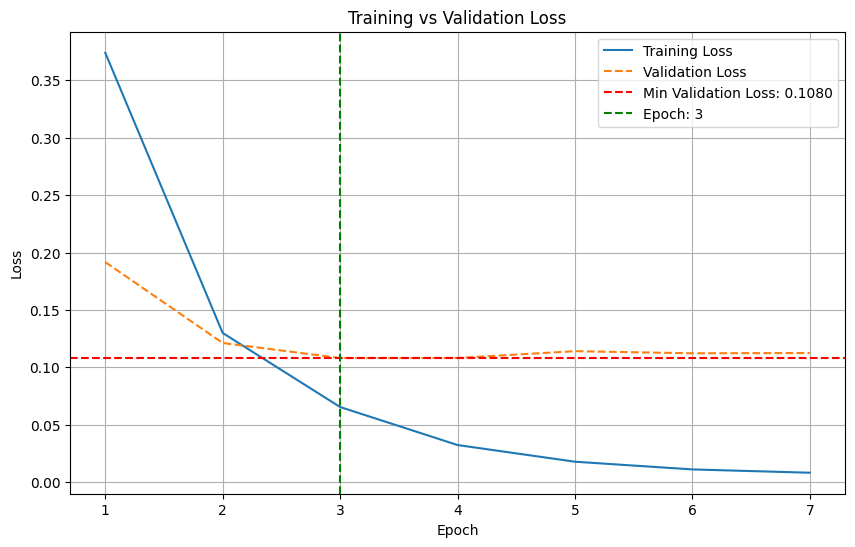

Macro-Averaged F1 Score: 0.6292

Micro-Averaged F1 Score: 0.7824

Weigthed-Averaged F1 Score: 0.7835

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.1429     0.2222     7         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.8776     0.8836     0.8805     146       

I-Activity                          0.7143     0.5556     0.6250     9         

B-Activity Data                     0.8905     0.9313     0.9104     131       

I-Activity Data                     0.6181     0.7607     0.6820     117       

B-Actor                             0.8806     0.8939     0.8872     132       

I-Actor                             0.8160     0.8947     0.8536     114       

B-Condition Specification           0.9333     0.5600     0.7000     25        

I-Condition Specification           0.6190     0.5652     0.5909     23        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7629, Precision: 0.8850, Recall: 0.8285, F1: 0.8553
Step 50, Loss: 0.1302, Precision: 0.9381, Recall: 0.9559, F1: 0.9467
Average training loss: 0.4093

Macro-Averaged F1 Score: 0.2249

Micro-Averaged F1 Score: 0.4550

Weigthed-Averaged F1 Score: 0.4367

Epoch 2/7
Training...
Step 0, Loss: 0.1374, Precision: 0.9389, Recall: 0.9563, F1: 0.9473
Step 50, Loss: 0.1296, Precision: 0.9623, Recall: 0.9644, F1: 0.9629
Average training loss: 0.1311

Macro-Averaged F1 Score: 0.3258

Micro-Averaged F1 Score: 0.6311

Weigthed-Averaged F1 Score: 0.6157

Epoch 3/7
Training...
Step 0, Loss: 0.0403, Precision: 0.9623, Recall: 0.9651, F1: 0.9633
Step 50, Loss: 0.0789, Precision: 0.9674, Recall: 0.9688, F1: 0.9676
Average training loss: 0.0629

Macro-Averaged F1 Score: 0.4065

Micro-Averaged F1 Score: 0.6826

Weigthed-Averaged F1 Score: 0.6739

Epoch 4/7
Training...
Step 0, Loss: 0.0506, Precision: 0.9672, Recall: 0.9685, F1: 0.9674
Step 50, Loss: 0.0342, Precision: 

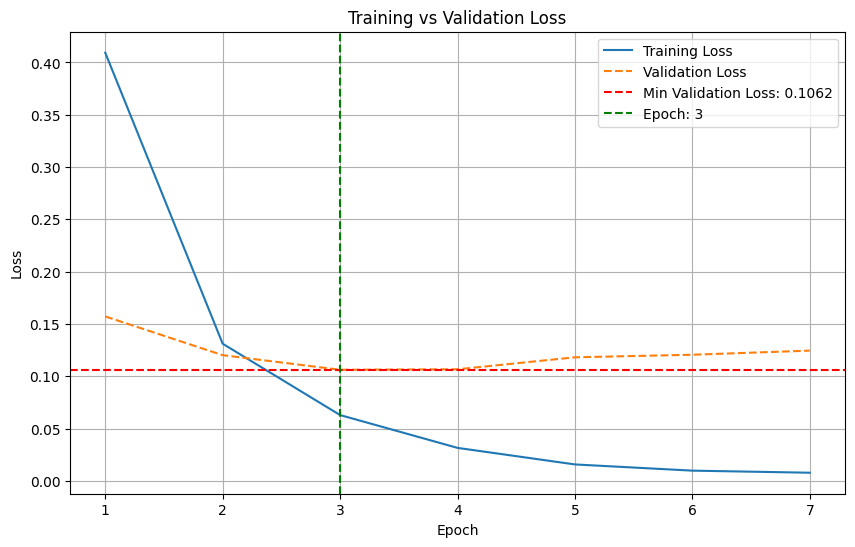

Macro-Averaged F1 Score: 0.4803

Micro-Averaged F1 Score: 0.6942

Weigthed-Averaged F1 Score: 0.6961

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.2000     0.3333     10        

I-AND Gateway                       0.2500     0.1667     0.2000     6         

B-Activity                          0.8125     0.8667     0.8387     105       

I-Activity                          0.1667     0.2000     0.1818     5         

B-Activity Data                     0.7477     0.8000     0.7729     100       

I-Activity Data                     0.5810     0.6854     0.6289     89        

B-Actor                             0.8602     0.8081     0.8333     99        

I-Actor                             0.7738     0.8784     0.8228     74        

B-Condition Specification           0.6522     0.6818     0.6667     22        

I-Condition Specification           0.4242     0.6364     0.5091     22        

B-Furth

In [ ]:
learning_rates = [2e-5, 3e-5, 4e-5, 5e-5]
result_lr = {}

for lr in learning_rates:
    print("\n---------------------------------------")
    print(f"Learning Rate: {lr}")
    print("---------------------------------------\n")
    lr_model, avg_macro_f1, avg_micro_f1, avg_weight_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, EPOCHS, label_map, lr)

    # Initialize the entry for this learning rate
    result_lr[lr] = {'avg_macro_f1': avg_macro_f1, 'avg_micro_f1':avg_micro_f1, 'avg_weight_f1': avg_weight_f1,  'label_f1': {}}

    for label, scores in label_f1.items():
        try:
            average_f1 = sum(scores) / len(scores)
            result_lr[lr]['label_f1'][label] = average_f1
        except ZeroDivisionError as zero:
            print(f"Zero division error for label {label}")

# Print the result to verify
print(result_lr)


In [ ]:
for item in result_lr:
  print('Learning rate:', item)
  print('macro avg f1 for all folds: ', round(result_lr[item]['avg_macro_f1'],4))
  print('micro avg f1 for all folds: ', round(result_lr[item]['avg_micro_f1'],4))
  print('weighted avg f1 for all folds: ', round(result_lr[item]['avg_weight_f1'],4))
  for label, score in result_lr[item]['label_f1'].items():
    if label.startswith("B-AND") or label.startswith("I-AND"):
      print(label, round(score,2))
  print('----')

Learning rate: 2e-05
macro avg f1 for all folds:  0.3883
micro avg f1 for all folds:  0.6745
weighted avg f1 for all folds:  0.6606
B-AND Gateway 0.0
I-AND Gateway 0.0
----
Learning rate: 3e-05
macro avg f1 for all folds:  0.4734
micro avg f1 for all folds:  0.7143
weighted avg f1 for all folds:  0.7052
B-AND Gateway 0.0
I-AND Gateway 0.0
----
Learning rate: 4e-05
macro avg f1 for all folds:  0.5188
micro avg f1 for all folds:  0.724
weighted avg f1 for all folds:  0.7205
B-AND Gateway 0.04
I-AND Gateway 0.11
----
Learning rate: 5e-05
macro avg f1 for all folds:  0.5734
micro avg f1 for all folds:  0.7437
weighted avg f1 for all folds:  0.7417
B-AND Gateway 0.15
I-AND Gateway 0.11
----


Fold 1


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.7692, Precision: 0.8838, Recall: 0.7706, F1: 0.8231
Step 50, Loss: 0.1953, Precision: 0.9315, Recall: 0.9496, F1: 0.9393
Average training loss: 0.3869

Macro-Averaged F1 Score: 0.2421

Micro-Averaged F1 Score: 0.5103

Weigthed-Averaged F1 Score: 0.4934

Epoch 2/6
Training...
Step 0, Loss: 0.2131, Precision: 0.9326, Recall: 0.9504, F1: 0.9405
Step 50, Loss: 0.0618, Precision: 0.9501, Recall: 0.9653, F1: 0.9570
Average training loss: 0.1369

Macro-Averaged F1 Score: 0.3804

Micro-Averaged F1 Score: 0.6796

Weigthed-Averaged F1 Score: 0.6472

Epoch 3/6
Training...
Step 0, Loss: 0.0876, Precision: 0.9509, Recall: 0.9646, F1: 0.9569
Step 50, Loss: 0.0269, Precision: 0.9668, Recall: 0.9705, F1: 0.9661
Average training loss: 0.0745

Macro-Averaged F1 Score: 0.4628

Micro-Averaged F1 Score: 0.7238

Weigthed-Averaged F1 Score: 0.7030

Epoch 4/6
Training...
Step 0, Loss: 0.0630, Precision: 0.9673, Recall: 0.9705, F1: 0.9662
Step 50, Loss: 0.0277, Precision: 

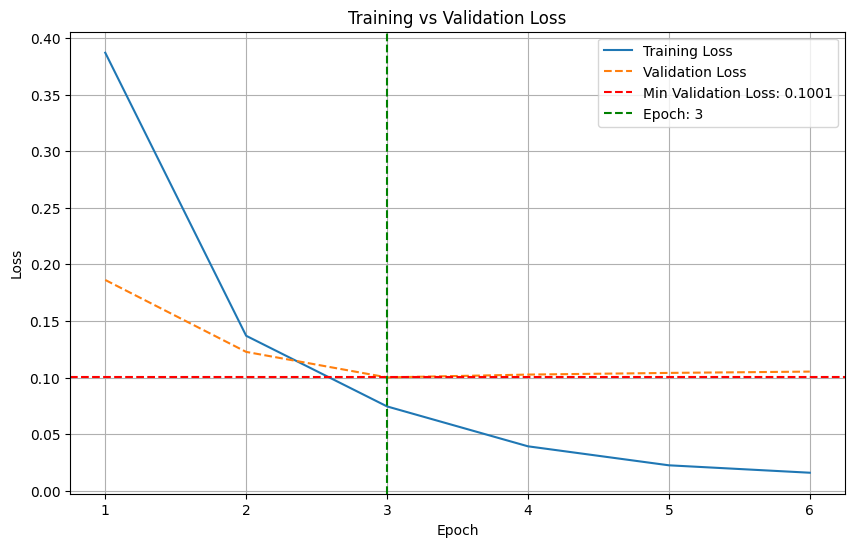

Macro-Averaged F1 Score: 0.5904

Micro-Averaged F1 Score: 0.7527

Weigthed-Averaged F1 Score: 0.7443

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     3         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.8983     0.9298     0.9138     114       

I-Activity                          0.8333     0.5556     0.6667     9         

B-Activity Data                     0.8667     0.8835     0.8750     103       

I-Activity Data                     0.7091     0.7879     0.7464     99        

B-Actor                             0.8646     0.9022     0.8830     92        

I-Actor                             0.7640     0.8293     0.7953     82        

B-Condition Specification           0.8571     0.4615     0.6000     13        

I-Condition Specification           0.5833     0.5833     0.5833     12        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.8567, Precision: 0.8839, Recall: 0.7046, F1: 0.7825
Step 50, Loss: 0.2383, Precision: 0.9182, Recall: 0.9242, F1: 0.9135
Average training loss: 0.4525

Macro-Averaged F1 Score: 0.0992

Micro-Averaged F1 Score: 0.3010

Weigthed-Averaged F1 Score: 0.2862

Epoch 2/6
Training...
Step 0, Loss: 0.2924, Precision: 0.9225, Recall: 0.9223, F1: 0.9155
Step 50, Loss: 0.0848, Precision: 0.9424, Recall: 0.9570, F1: 0.9488
Average training loss: 0.1592

Macro-Averaged F1 Score: 0.3117

Micro-Averaged F1 Score: 0.5813

Weigthed-Averaged F1 Score: 0.5620

Epoch 3/6
Training...
Step 0, Loss: 0.1143, Precision: 0.9458, Recall: 0.9583, F1: 0.9514
Step 50, Loss: 0.0763, Precision: 0.9553, Recall: 0.9616, F1: 0.9572
Average training loss: 0.0794

Macro-Averaged F1 Score: 0.3653

Micro-Averaged F1 Score: 0.6430

Weigthed-Averaged F1 Score: 0.6319

Epoch 4/6
Training...
Step 0, Loss: 0.1043, Precision: 0.9557, Recall: 0.9614, F1: 0.9557
Step 50, Loss: 0.0308, Precision: 

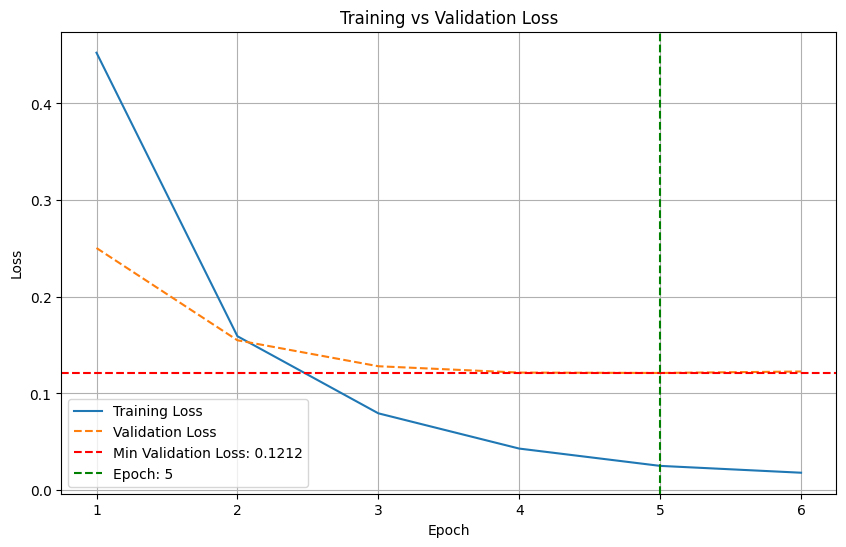

Macro-Averaged F1 Score: 0.5054

Micro-Averaged F1 Score: 0.6978

Weigthed-Averaged F1 Score: 0.6928

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     12        

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8540     0.8797     0.8667     133       

I-Activity                          1.0000     0.4615     0.6316     13        

B-Activity Data                     0.8306     0.8443     0.8374     122       

I-Activity Data                     0.5734     0.7523     0.6508     109       

B-Actor                             0.7792     0.7407     0.7595     81        

I-Actor                             0.5263     0.6557     0.5839     61        

B-Condition Specification           0.9412     0.5333     0.6809     30        

I-Condition Specification           0.3889     0.4667     0.4242     30        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.6187, Precision: 0.8586, Recall: 0.8865, F1: 0.8723
Step 50, Loss: 0.1735, Precision: 0.9347, Recall: 0.9521, F1: 0.9422
Average training loss: 0.3644

Macro-Averaged F1 Score: 0.2573

Micro-Averaged F1 Score: 0.5214

Weigthed-Averaged F1 Score: 0.5016

Epoch 2/6
Training...
Step 0, Loss: 0.1329, Precision: 0.9408, Recall: 0.9526, F1: 0.9445
Step 50, Loss: 0.0580, Precision: 0.9623, Recall: 0.9684, F1: 0.9634
Average training loss: 0.1130

Macro-Averaged F1 Score: 0.4273

Micro-Averaged F1 Score: 0.6989

Weigthed-Averaged F1 Score: 0.6771

Epoch 3/6
Training...
Step 0, Loss: 0.0563, Precision: 0.9616, Recall: 0.9693, F1: 0.9638
Step 50, Loss: 0.0799, Precision: 0.9676, Recall: 0.9736, F1: 0.9700
Average training loss: 0.0571

Macro-Averaged F1 Score: 0.5170

Micro-Averaged F1 Score: 0.7454

Weigthed-Averaged F1 Score: 0.7345

Epoch 4/6
Training...
Step 0, Loss: 0.0789, Precision: 0.9694, Recall: 0.9735, F1: 0.9706
Step 50, Loss: 0.0254, Precision: 

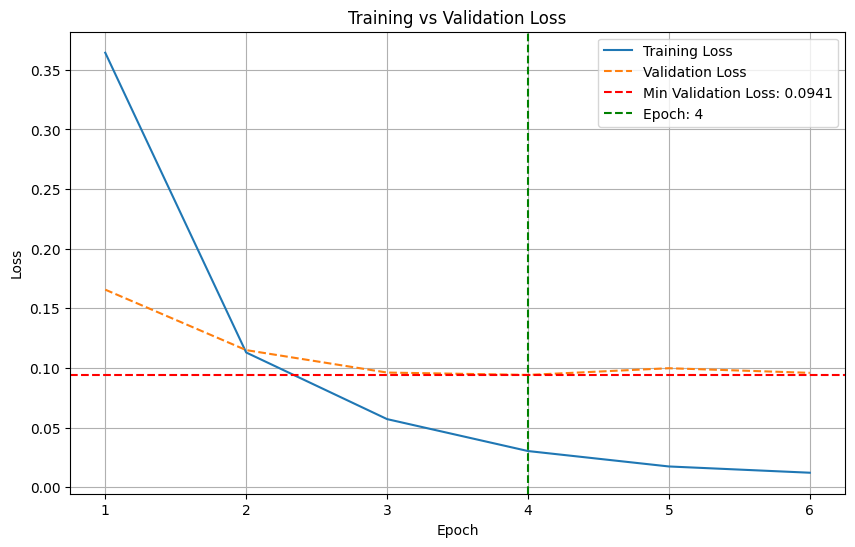

Macro-Averaged F1 Score: 0.5682

Micro-Averaged F1 Score: 0.7551

Weigthed-Averaged F1 Score: 0.7473

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     13        

I-AND Gateway                       0.0000     0.0000     0.0000     7         

B-Activity                          0.8219     0.9375     0.8759     128       

I-Activity                          1.0000     0.3636     0.5333     11        

B-Activity Data                     0.7969     0.8430     0.8193     121       

I-Activity Data                     0.5857     0.7961     0.6749     103       

B-Actor                             0.8716     0.9406     0.9048     101       

I-Actor                             0.8298     0.8966     0.8619     87        

B-Condition Specification           0.7368     0.6667     0.7000     21        

I-Condition Specification           0.7619     0.8000     0.7805     20        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.5437, Precision: 0.8190, Recall: 0.8644, F1: 0.8372
Step 50, Loss: 0.1951, Precision: 0.9255, Recall: 0.9448, F1: 0.9341
Average training loss: 0.3706

Macro-Averaged F1 Score: 0.2326

Micro-Averaged F1 Score: 0.5137

Weigthed-Averaged F1 Score: 0.5122

Epoch 2/6
Training...
Step 0, Loss: 0.2248, Precision: 0.9312, Recall: 0.9489, F1: 0.9398
Step 50, Loss: 0.1129, Precision: 0.9539, Recall: 0.9613, F1: 0.9564
Average training loss: 0.1344

Macro-Averaged F1 Score: 0.3543

Micro-Averaged F1 Score: 0.7020

Weigthed-Averaged F1 Score: 0.6925

Epoch 3/6
Training...
Step 0, Loss: 0.1107, Precision: 0.9545, Recall: 0.9612, F1: 0.9565
Step 50, Loss: 0.0568, Precision: 0.9650, Recall: 0.9666, F1: 0.9651
Average training loss: 0.0710

Macro-Averaged F1 Score: 0.4827

Micro-Averaged F1 Score: 0.7481

Weigthed-Averaged F1 Score: 0.7494

Epoch 4/6
Training...
Step 0, Loss: 0.0899, Precision: 0.9649, Recall: 0.9668, F1: 0.9653
Step 50, Loss: 0.0294, Precision: 

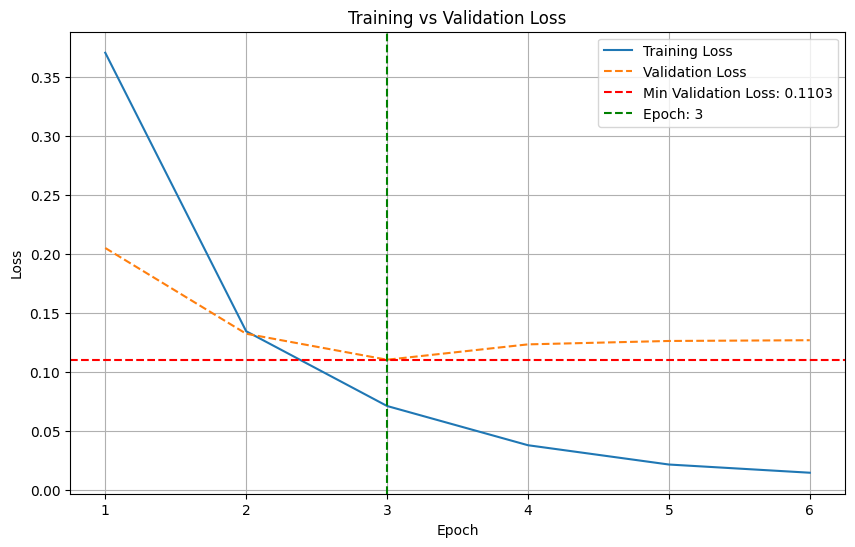

Macro-Averaged F1 Score: 0.5973

Micro-Averaged F1 Score: 0.7774

Weigthed-Averaged F1 Score: 0.7830

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.5000     0.6667     4         

I-AND Gateway                       0.1250     0.3333     0.1818     3         

B-Activity                          0.9286     0.9070     0.9176     129       

I-Activity                          1.0000     0.5714     0.7273     7         

B-Activity Data                     0.8468     0.8750     0.8607     120       

I-Activity Data                     0.6585     0.7297     0.6923     111       

B-Actor                             0.9108     0.8827     0.8966     162       

I-Actor                             0.8082     0.8676     0.8369     136       

B-Condition Specification           0.5294     0.6923     0.6000     13        

I-Condition Specification           0.2500     0.5000     0.3333     12        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.7775, Precision: 0.8690, Recall: 0.8618, F1: 0.8650
Step 50, Loss: 0.1838, Precision: 0.9526, Recall: 0.9380, F1: 0.9347
Average training loss: 0.4341

Macro-Averaged F1 Score: 0.1799

Micro-Averaged F1 Score: 0.4310

Weigthed-Averaged F1 Score: 0.4114

Epoch 2/6
Training...
Step 0, Loss: 0.2487, Precision: 0.9536, Recall: 0.9407, F1: 0.9376
Step 50, Loss: 0.0791, Precision: 0.9644, Recall: 0.9689, F1: 0.9660
Average training loss: 0.1575

Macro-Averaged F1 Score: 0.3691

Micro-Averaged F1 Score: 0.6462

Weigthed-Averaged F1 Score: 0.6410

Epoch 3/6
Training...
Step 0, Loss: 0.0893, Precision: 0.9659, Recall: 0.9694, F1: 0.9671
Step 50, Loss: 0.0471, Precision: 0.9704, Recall: 0.9725, F1: 0.9711
Average training loss: 0.0793

Macro-Averaged F1 Score: 0.4229

Micro-Averaged F1 Score: 0.7078

Weigthed-Averaged F1 Score: 0.7023

Epoch 4/6
Training...
Step 0, Loss: 0.0415, Precision: 0.9705, Recall: 0.9729, F1: 0.9714
Step 50, Loss: 0.0566, Precision: 

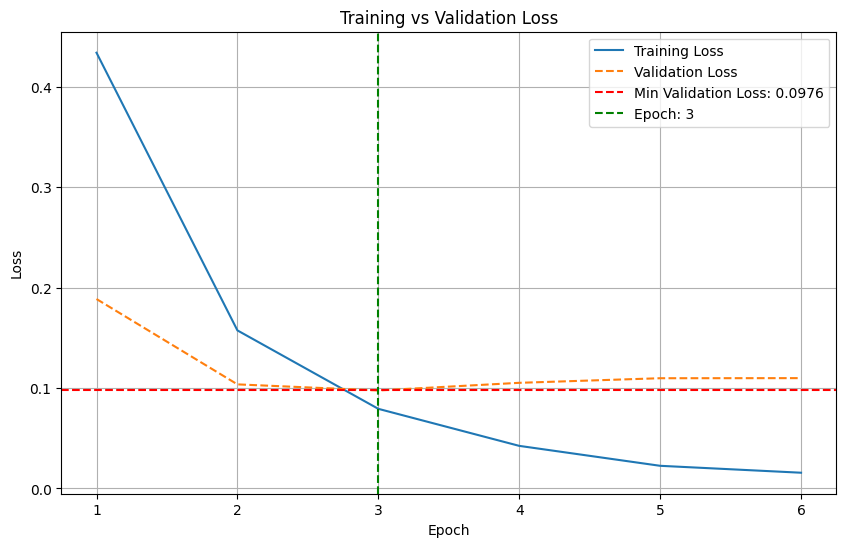

Macro-Averaged F1 Score: 0.4961

Micro-Averaged F1 Score: 0.7241

Weigthed-Averaged F1 Score: 0.7280

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.3750     0.5455     8         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8167     0.8991     0.8559     109       

I-Activity                          0.0000     0.0000     0.0000     4         

B-Activity Data                     0.7810     0.8039     0.7923     102       

I-Activity Data                     0.6019     0.7065     0.6500     92        

B-Actor                             0.8812     0.8396     0.8599     106       

I-Actor                             0.8298     0.8478     0.8387     92        

B-Condition Specification           0.7222     0.6190     0.6667     21        

I-Condition Specification           0.4483     0.6190     0.5200     21        

B-Furth

In [ ]:
epoch_best = 6 #check 4

learning_rate = 5e-05
best_model, avg_macro_f1, avg_micro_f1, avg_weight_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, epoch_best, label_map, learning_rate)


To train on the (whole) dataset, save the model and download it for later use without having to retrain the model. Uncomment for it to work.

#3. Model Saving for Pipeline

First we need to create a subset of the data to keep separate documents for testing. These documents are then also removed from the original training data before it goes through training.

##3.1.1 Remove 6 documents for testing


In [ ]:
#@title Training Model
def train_model_pipeline(input_data_pipeline, BATCH_SIZE, EPOCHS, label_map, learning_rate):
  # Training of the model
  # Instantiate the dataset and dataloader for validation
  train_data, val_data = train_test_split(input_data_pipeline, test_size=0.2, random_state=SEED)

  train_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in train_data],
      labels=[entry['ner-tags'] for entry in train_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )
  # Instantiate the dataset and dataloader for validation
  val_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in val_data],
      labels=[entry['ner-tags'] for entry in val_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )

  #Initialize the DataLoader objects
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

  #loading the desired model: each fold we need start fresh
  model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS)

  # Fine-tuning setup, can be changed for model optimisation
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
  total_steps = len(train_loader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  # Using funtion defined above to train the model and obtain the losses for plotting at the same time
  model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map)
  plot_losses(training_losses,validation_losses)

  #Evaluating the model in this fold
  val_metrics = evaluate_model(model, val_loader, label_map)

  #So it is printed pretty :)
  header = "{:<35} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1")
  row_format = "{:<35} {:<10} {:<10} {:<10}\n"
  print(header)
  for label, metrics in val_metrics['detailed_metrics'].items():
    print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1'])))

  # Now, label_f1_scores[label] holds a list of F1 scores for that label across all folds
  return model

Based on the testing on proper learning rates and looking at the loss graphs we set the epochs to 5 and the lr to ```5e-05```.

{'doc-8.2', 'doc-10.7', 'doc-20.5 - edit pictures', 'doc-10.12', 'doc-3.1', 'doc-9.3'}
data loaded


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.9968, Precision: 0.8640, Recall: 0.6526, F1: 0.7427
Step 47, Loss: 0.1220, Precision: 0.9129, Recall: 0.9336, F1: 0.9195
Average training loss: 0.4330

Macro-Averaged F1 Score: 0.1623

Micro-Averaged F1 Score: 0.3399

Weigthed-Averaged F1 Score: 0.3273

Epoch 2/6
Training...
Step 0, Loss: 0.3262, Precision: 0.9137, Recall: 0.9349, F1: 0.9209
Step 47, Loss: 0.1475, Precision: 0.9581, Recall: 0.9595, F1: 0.9556
Average training loss: 0.1583

Macro-Averaged F1 Score: 0.3228

Micro-Averaged F1 Score: 0.6328

Weigthed-Averaged F1 Score: 0.6172

Epoch 3/6
Training...
Step 0, Loss: 0.1701, Precision: 0.9572, Recall: 0.9597, F1: 0.9555
Step 47, Loss: 0.0609, Precision: 0.9597, Recall: 0.9630, F1: 0.9599
Average training loss: 0.0790

Macro-Averaged F1 Score: 0.3843

Micro-Averaged F1 Score: 0.6677

Weigthed-Averaged F1 Score: 0.6516

Epoch 4/6
Training...
Step 0, Loss: 0.0595, Precision: 0.9597, Recall: 0.9639, F1: 0.9605
Step 47, Loss: 0.0355, Precision: 

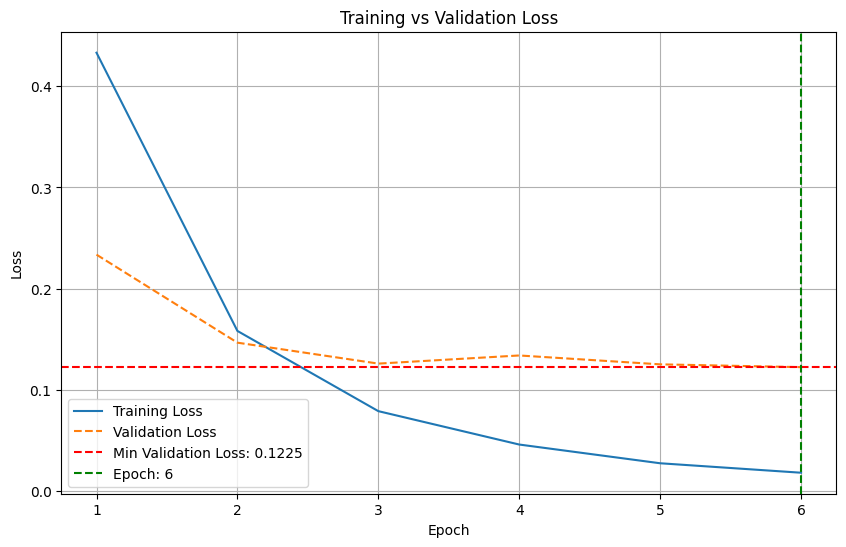

Macro-Averaged F1 Score: 0.5092

Micro-Averaged F1 Score: 0.7167

Weigthed-Averaged F1 Score: 0.7090

Label                               Precision  Recall     F1        

I-XOR Gateway                       0.0000     0.0000     0.0000    

I-AND Gateway                       0.0000     0.0000     0.0000    

I-Activity                          1.0000     0.2000     0.3333    

I-Actor                             0.7872     0.9024     0.8409    

I-Activity Data                     0.5254     0.6596     0.5849    

B-Further Specification             0.6250     0.2778     0.3846    

B-XOR Gateway                       0.8800     0.7097     0.7857    

O                                   0.6359     0.7299     0.6796    

B-Activity                          0.7891     0.8860     0.8347    

B-Activity Data                     0.7179     0.7850     0.7500    

I-Further Specification             0.2500     0.2667     0.2581    

B-AND Gateway                       0.0000     0.0000     

In [ ]:
def pick_and_remove_documents(data, num_docs, SEED):
    # Pick 6 documents at random
    random.seed(SEED)
    selected_docs_indices = random.sample(range(len(data)), num_docs)
    selected_docs = [data[i] for i in selected_docs_indices]

    # Remove the selected documents from the original data
    remaining_docs = [doc for i, doc in enumerate(data) if i not in selected_docs_indices]

    return selected_docs, remaining_docs

try:

  selected_docs, remaining_docs = pick_and_remove_documents(unflattened_data, 6, SEED)
  folder_path = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/NER_TESTING/'

  check= set()
  for document in selected_docs:
    for sentence in document:
      check.add(sentence['document name'])
  print(check)

  # here the selected documents are saved for pipeline testing
  for i, document in enumerate(selected_docs):
        file_path = os.path.join(folder_path, f'document_{i+1}.json')
        with open(file_path, 'w') as file:
            for sentence in document:
                # Convert the sentence to a JSON string and write it with a newline
                json_line = json.dumps(sentence) + '\n'
                file.write(json_line)

  input_data_pipeline = [item for group in remaining_docs for item in group]

  if input_data_pipeline:
    print('data loaded')

  #training of the model without the 6 left out documents
  epochs_pipe= 6 #DONE
  lr= 5e-05
  model2 = train_model_pipeline(input_data_pipeline, BATCH_SIZE, epochs_pipe, label_map, lr)

except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")

##3.2 Training and saving the model



In [ ]:
# Save the model to a file
# Assuming 'best_model' is your trained model and 'tokenizer' is your tokenizer
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base/6DOCLEFTOUT/MODEL/"
tokenizer_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base/6DOCLEFTOUT/TOKENIZER/"

# Save the model & tokenizer
model2.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

('/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base/6DOCLEFTOUT/TOKENIZER/tokenizer_config.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base/6DOCLEFTOUT/TOKENIZER/special_tokens_map.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base/6DOCLEFTOUT/TOKENIZER/vocab.txt',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base/6DOCLEFTOUT/TOKENIZER/added_tokens.json')